#Forest Cover Type Prediction

*Authors: Chitra Agastya, Bobby Calzaretta, Marcus Streips, and Hailey Wu*

August 4th, 2019

MIDS W207 Professor: Yacov salomon

## I. Abstract

Analysis on forest cover types is critical for ecosystem management in order to prevent large-scale disasters such as wildfires. Both manual classification and sensor monitoring are difficult to scale across the nation. This report attempts to predict the predominant tree types with machine learning techniques based on cartographic information such as aspect, elevation, soil type, and wilderness area, *etc.* to facilitate ecosystem management.  A large portion of the work presented here to address this problem involves feature selection, transformation and engineering informed by background study.  Various machine learning models such as logistic regression, neural network, tree-based models and multi-stage ensembles are used to enhance the accuracy. Using these methods, the best accuracy reaches 86.44% on holdout test data.

## II. Introduction

As a crucial ecological resource, forests have long been analyzed to preserve the balance of ecosystem, such as biodiversity, water resources, soil fertility and climatological cycles. One key characteristic of forests are the predominant kind of flora cover for a given area, which is part of the foundation for an ecosystem. It can inform both the strength and vulnerability of certain forest area to issues such as wildfires. As forests in national parks tend to be dense and in remote areas, manual classification of trees is inherently arduous and time consuming. Remote sensing data has provided an opportunity to monitor spatial and temporal information. However, the time and cost for sensing implementation limits a scalable solution for thorough forest analysis. 

$~$


This study aims to use strictly cartographic variables (as opposed to remotely sensed data or satellite imagery) to predict the one of the seven forest cover types for each 30x30 meter area of the Roosevelt National Forest in Colorado.  This multi-class problem is approachable using several different machine learning techniques. The work will involve feature selection, transformation and engineering as well. The major purpose of this study is to enhance the accuracy of prediction for forever cover type from cartographic data.  The report approaches this problem with a particular focus on wild fires.  Specifically, just as classes of vegetation determine an area's potential for fire ignition and the rate at which fire spreads, fires reshape landscapes determining what classes of vegetation can grow in their aftermath.  This report introduces two features to help account for this relationship and hopefully improve the generalizeability of our models: the Potential Influence of Solar Radiation ("PSR") and an approximation for Topographic Wetness Index ("TWI").

$~$


Classification is important as it allows forestry services to identify fire-prone species (such as spruce) for pruning to help reduce the incidence of forest fires, which this report considers as a key use case. However, solutions to problems of this nature have broad applications within the domain of forestry and elsewhere.  Cover type prediction can also facilitate the identification of invasive species for removal.  Additionally, a time series approach to cover classification provides for the analysis of ecosystem changes and allows forestry services to anticipate of resource requirements for forest maintenance.  Beyond forestry, analyses of this type could have meaningful economic and policy implications.  These cartographic data and the classification of corresponding flora could allow for more reliable predictions in crop yields and prices, the identification of fire-prone areas near residential neighborhoods for preemptive responses, and the ability to form expectations on the impact of global warming on a region.  If machine learning techniques can be leveraged to reduce the resource and time costs of this type of classification problem, then these benefits could be delivered more readily.

## III. Methodology

### Library

In [0]:
# load packages for analysis
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# create testing and training data sets
from sklearn.model_selection import train_test_split

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

#Import libraries for data transformations
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler #opting for Robust
from sklearn.preprocessing import RobustScaler #using this due to outliers
from sklearn.preprocessing import MinMaxScaler #opting for Robust
from sklearn.preprocessing import Normalizer 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


# https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1lpnAdPp_BIs4kbj97rx-zatuUECuhu2h'

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
dataset = pd.read_csv('Filename.csv')
dataset = dataset.iloc[:,1:]

seed = 0

     |████████████████████████████████| 993kB 5.1MB/s 
1lpnAdPp_BIs4kbj97rx-zatuUECuhu2h


### Data Description

The Kaggle Forest Cover Type Prediction problem requires the identification of forest canopy cover types for select 30 x 30 meter areas of the Roosevelt National Forest in northern Colorado. The data include 13 main categories of cartographic fields with two fields (soil type and cover type) being categorical classifications that have been binarized.  

$~$

The data relied upon in this analysis come from Kaggle's ["Forest Cover Type Prediction" challenge](https://www.kaggle.com/c/forest-cover-type-prediction).  The seven classes of forest cover type are integer-coded as follows:


  1.   Spruce/Fir
  2.   Lodgepole Pine
  3.   Ponderosa Pine
  4.   Cottonwood/Willow
  5.   Aspen
  6.   Douglas-fir
  7.   Krummholz


The data are pre-segregated into training and test sets.  The training data contain 15,120 observations with 13 feature types and cover type information.  The test data contain 565,892 observations with the same 13 feature types.  The test data exclude cover type information; therefore, we consider this Kaggle dataset the "evaluation data," and we further divide the Kaggle training data into our own training and test data sets.



### Data Fields

The data contain the following cartographic features with decriptions from Kaggle:

 &emsp;**Elevation** - Elevation in meters  
 &emsp;**Aspect** - Aspect in degrees azimuth  
 &emsp;**Slope** - Slope in degrees  
 &emsp;**Horizontal_Distance_To_Hydrology** - Horz Dist to nearest surface water features  
 &emsp;**Vertical_Distance_To_Hydrology** - Vert Dist to nearest surface water features  
 &emsp;**Horizontal_Distance_To_Roadways** - Horz Dist to nearest roadway  
 &emsp;**Hillshade_9am** (0 to 255 index) - Hillshade index at 9am, summer solstice  
 &emsp;**Hillshade_Noon** (0 to 255 index) - Hillshade index at noon, summer solstice  
 &emsp;**Hillshade_3pm** (0 to 255 index) - Hillshade index at 3pm, summer solstice  
 &emsp;**Horizontal_Distance_To_Fire_Points** - Horz Dist to nearest wildfire ignition points  
 &emsp;**Wilderness_Area** (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation  
 &emsp;**Soil_Type** (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation  
 &emsp;**Cover_Type** (7 types, integers 1 to 7) - Forest Cover Type designation  
  
 $~$
 
The soil type and cover type fields are binarized categorical features.  The soil type field is broken out into the following 40 binary categories:

1. Cathedral family - Rock outcrop complex, extremely stony.
2. Vanet - Ratake families complex, very stony.
3. Haploborolis - Rock outcrop complex, rubbly.
4. Ratake family - Rock outcrop complex, rubbly.
5. Vanet family - Rock outcrop complex complex, rubbly.
6. Vanet - Wetmore families - Rock outcrop complex, stony.
7. Gothic family.
8. Supervisor - Limber families complex.
9. Troutville family, very stony.
1.  Bullwark - Catamount families - Rock outcrop complex, rubbly.
1.  Bullwark - Catamount families - Rock land complex, rubbly.
12. Legault family - Rock land complex, stony.
13. Catamount family - Rock land - Bullwark family complex, rubbly.
14. Pachic Argiborolis - Aquolis complex.
15. unspecified in the USFS Soil and ELU Survey.
16. Cryaquolis - Cryoborolis complex.
17. Gateview family - Cryaquolis complex.
18. Rogert family, very stony.
19. Typic Cryaquolis - Borohemists complex.
20. Typic Cryaquepts - Typic Cryaquolls complex.
21. Typic Cryaquolls - Leighcan family, till substratum complex.
22. Leighcan family, till substratum, extremely bouldery.
23. Leighcan family, till substratum - Typic Cryaquolls complex.
24. Leighcan family, extremely stony.
25. Leighcan family, warm, extremely stony.
26. Granile - Catamount families complex, very stony.
27. Leighcan family, warm - Rock outcrop complex, extremely stony.
28. Leighcan family - Rock outcrop complex, extremely stony.
29. Como - Legault families complex, extremely stony.
30. Como family - Rock land - Legault family complex, extremely stony.
31. Leighcan - Catamount families complex, extremely stony.
32. Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
33. Leighcan - Catamount families - Rock outcrop complex, extremely stony.
34. Cryorthents - Rock land complex, extremely stony.
35. Cryumbrepts - Rock outcrop - Cryaquepts complex.
36. Bross family - Rock land - Cryumbrepts complex, extremely stony.
37. Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
38. Leighcan - Moran families - Cryaquolls complex, extremely stony.
39. Moran family - Cryorthents - Leighcan family complex, extremely stony.
40. Moran family - Cryorthents - Rock land complex, extremely stony.

$~$

The wilderness areas are broken out into the following four binary categories :

1. Rawah Wilderness Area
2.  Neota Wilderness Area
3. Comanche Peak Wilderness Area
4. Cache la Poudre Wilderness Area

### Data Visualization

**Sanity Check**

Before delving into the data we consider some basic checks of completeness and balance.  We see that all classes have an equal presence; therefore, class re-balancing would not appear to be necessary.  Additionally, the soil data is essentially one-hot encoded with some fields taking constant values.  Lastly, we find that all features appear to be  complete, non-null int64 type (Appendix 1).

In [0]:
# Number of instances belonging to each class

dataset.groupby('Cover_Type').size()

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

In [0]:
#any records where there are more than one soil type?
soil = dataset.iloc[:,14:54]
soil.dtypes
soil[soil.sum(axis = 1) >1]

,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40


**Histograms of non binary data columns**

This section shows histograms of our continuous variables. There are ten such variables in our dataset: Elevation, Aspect, Slope, Hilshade_9am, Hillshade_Noon, Hillshade_3pm, Horizontal_Distance_To_Fire_Points, Horizontal_Distance_To_Roadways, Vertical_Distance_To_Hydrology and Horizontal_Distance_To_Hydrology.

From the histograms we see some distributions are:
*   multimodal (*e.g.*, Elevation, Aspect),  
*   left skewed (*e.g.*, Hilshade_9am, Hillshade_Noon) 
*   right skewed (*e.g.*, Horizontal_Distance_To_Fire_Points, Horizontal_Distance_To_Roadways, Vertical_Distance_To_Hydrology and Horizontal_Distance_To_Hydrology)

       
Some of the distributions also reveal some outlier data points (*e.g.*, Vertical_Distance_To_Hydrology).

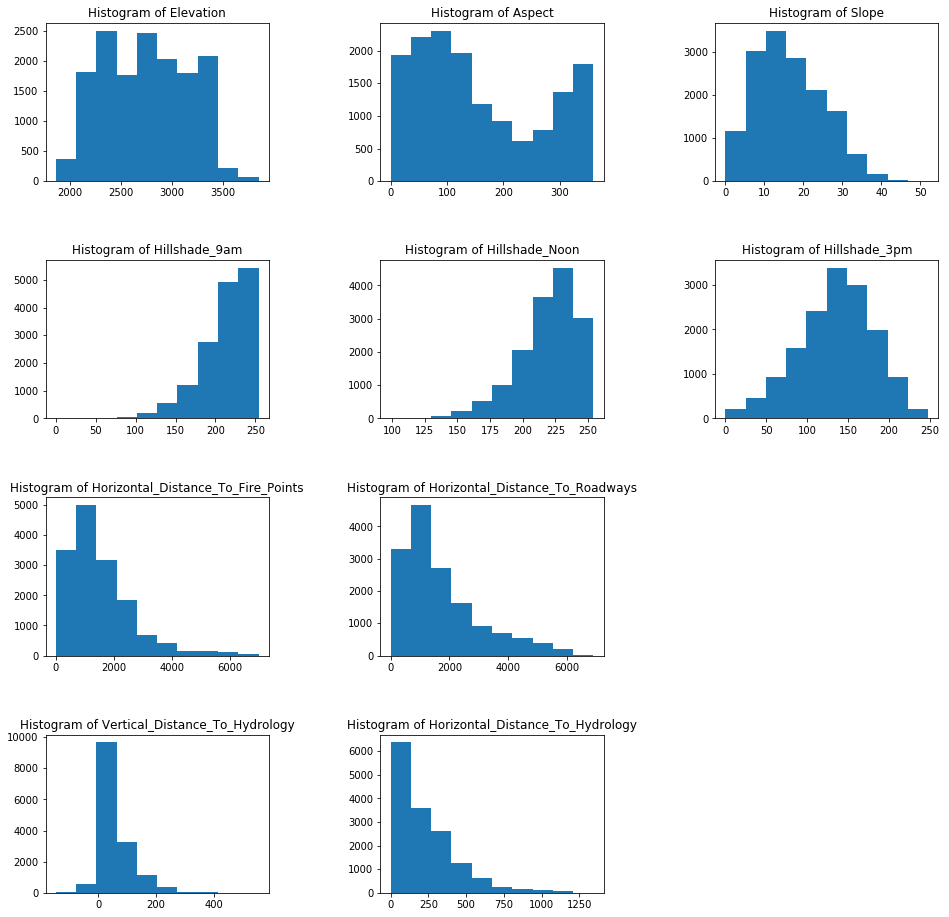

In [0]:
def create_subplot(i, j, axis, data, col_name):
    axis[i,j].hist(data[col_name])
    axis[i,j].set_title('Histogram of {}'.format(col_name))

fig, ax = plt.subplots(nrows=4, ncols=3, sharex=False, sharey=False, figsize = (16, 16))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

create_subplot(0,0,ax,dataset, 'Elevation')
create_subplot(0,1,ax,dataset, 'Aspect')
create_subplot(0,2,ax,dataset, 'Slope')

create_subplot(1,0,ax,dataset, 'Hillshade_9am')
create_subplot(1,1,ax,dataset, 'Hillshade_Noon')
create_subplot(1,2,ax,dataset, 'Hillshade_3pm')

create_subplot(2,0,ax,dataset, 'Horizontal_Distance_To_Fire_Points')
create_subplot(2,1,ax,dataset, 'Horizontal_Distance_To_Roadways')

create_subplot(3,0,ax,dataset, 'Vertical_Distance_To_Hydrology')
create_subplot(3,1,ax,dataset, 'Horizontal_Distance_To_Hydrology')

fig.delaxes(ax[2][2])
fig.delaxes(ax[3][2])

**Correlation between non binary features**

Below we plot the correlation matrix between our ten continuous variables to see which variables have influence over the others. We make the following observations based on the correlation matrix:

*  Aspect has high correlation with hillshade_9am and hillshade_3pm.
*  Hillshade_3pm has a high correlation with hillshade_9am and hillshade_noon. It might suffice to pick just one of these hillshade values in our feature set.
*  Horizontal distance to hydrology has high correlation with vertical distance to hydrology. Perhaps we can come up with a new distance metric that combines both of these (e.g. Euclidean distance or cosine distance) and use this new distance metric in our feature set.
*  Elevation has high correlation with horizontal distance to roadways and a somewhat high correlation to horizontal distance to fire points.

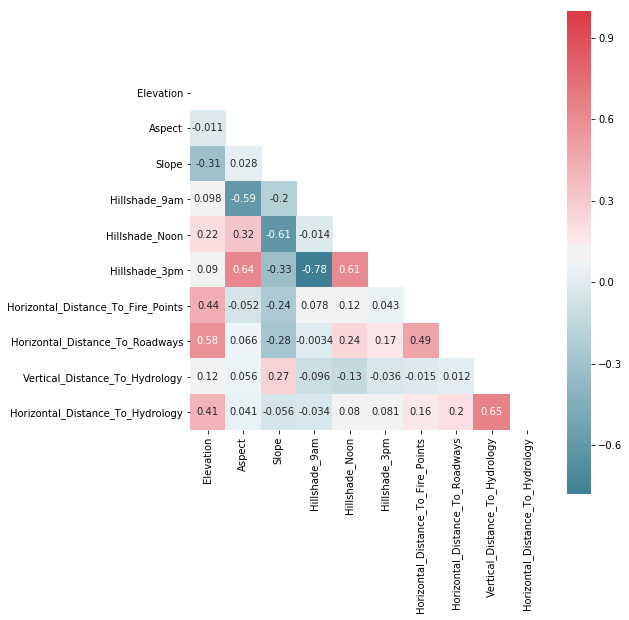

In [0]:
#Correlation heat map for non binary features
cols = ['Elevation', 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 
        'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Roadways',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology']
all_data = dataset[cols]
all_labels = cols

#features are columns. So set rowvar to False
corrcf = np.corrcoef(all_data, rowvar=False)
# create mask for upper triangle
mask = np.zeros_like(corrcf,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

# Use seaborn to create the correlation heatmap.
fig, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrcf,mask=mask, yticklabels=all_labels, xticklabels=all_labels, annot=True,
            cmap=cmap, ax=ax, square=True)
fig.tight_layout()

**Continuous Features by Cover Type**

Since the problem at hand is to predict the cover type, we try to explore how the distribution of the different variables look when grouped by cover type. The plots below show a strong clear class separation of classes in the case of Elevation. The separation is not very clear for all the other variables indicating that we need further feature selection/engineering to help separate classes better.

In [0]:
def draw_pairplots_full(data, cols, labels):
    sns.set(style="ticks")
    g = sns.PairGrid(data=data, vars = cols, hue='Cover_Type', diag_sharey=False) 
    g = g.map_lower(plt.scatter, s=10, alpha=0.3) #, 
    g = g.map_upper(sns.kdeplot)
    g = g.map_diag(sns.distplot)
    fig = g.fig 
    fig.subplots_adjust(top=0.93)
    fig.suptitle('Continuous Features by Cover Type', fontsize=20)
    fig.legend(handles=g._legend_data.values(), labels=g._legend_data.keys(), loc='upper left', ncol=7)

def visualize_by_covertype(data):
    new_data = data.copy()
    new_data.rename(columns={"Horizontal_Distance_To_Hydrology": "H_Hydro", 
                             "Vertical_Distance_To_Hydrology": "V_Hydro",
                             "Horizontal_Distance_To_Roadways" : "H_RoadW",
                             "Horizontal_Distance_To_Fire_Points" : "H_FirePt"}, inplace=True)
    
    draw_pairplots_full(new_data, new_data.columns[:10], ['1', '2', '3', '4','5', '6', '7'])

visualize_by_covertype(dataset)

Output hidden; open in https://colab.research.google.com to view.

**Box Plots**

In continuing with the theme from above, we try to analyze the box plots between the non-binary variables in our data set based on cover type. From our box plots we observer that:

* Elevation gives us much information regarding the various cover types.
* Aspect mean, max and min do not seem to give much variation among different cover types.

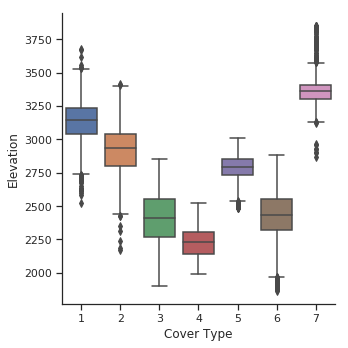

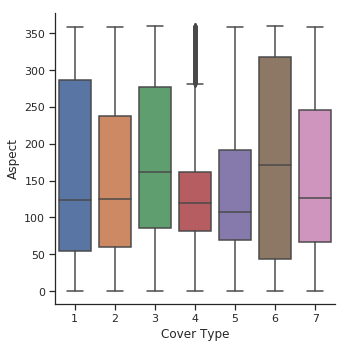

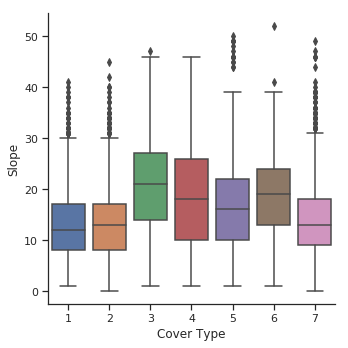

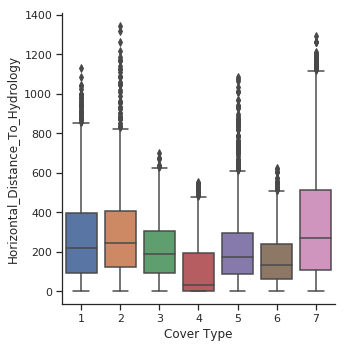

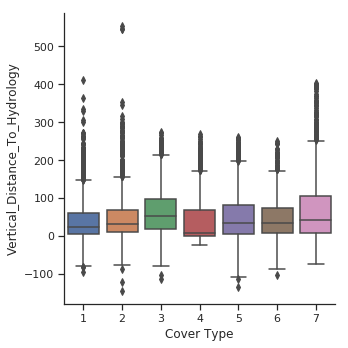

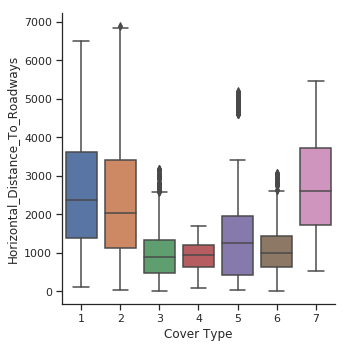

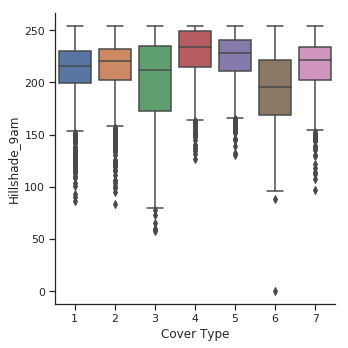

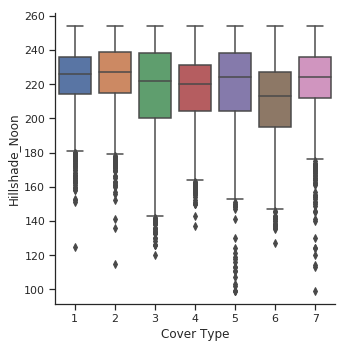

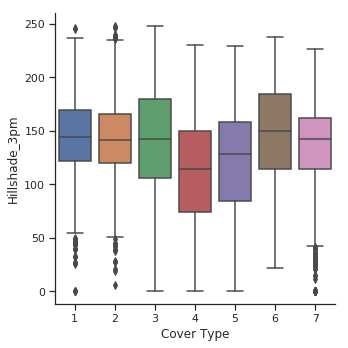

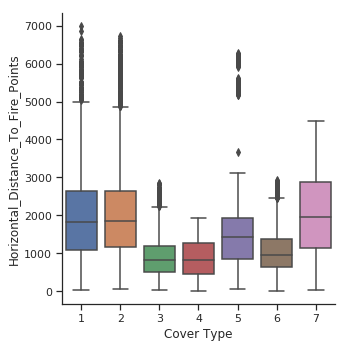

In [0]:
# Boxplot between non-binary variable and forest type

features = dataset.columns.tolist()
  
for name in features[0:10]:
  title = name + "vs. Cover Type"
  g = sns.factorplot("Cover_Type", name, data=dataset, kind="box")
  g.set_axis_labels("Cover Type", name)
  sns.axes_style(style='ticks')

**Categorical Variables by Cover Type**

We also look at the distribution of our categorical variables (Soil Types and Wilderness Areas) grouped by Cover Type using bar plots for our categorical variables . 

From our plots for soil types we observe that:

* Not all soil types occur in all cover types
* Soil type 10 has the most observations with largest occurances for cover type 6
* Cover type 7 is more common in soil types 38, 39, 40

From our plots for wilderness, we observe that not all wilderness areas occur in all cover types. 
* Cover types 1 and 7 do not include wilderness area 4 and 
* Cover types 3 and 6 does not include wilderness areas 1 and 2
* Cover type 5 does not includ wilderness areas 2 and 4
* Cover type 4 only includes wilderness area 4

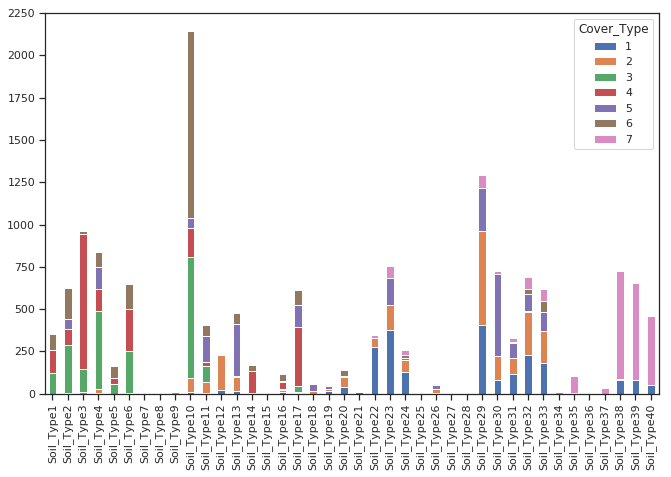

In [0]:
# Stacked bar graph between soil variables and cover type

soil_binary = filter(lambda k: 'Soil' in k, np.array(features))
covergroup = dataset[soil_binary].groupby(dataset['Cover_Type']).sum()
covergroup.T.plot(kind='bar', stacked=True, figsize=(11,7))

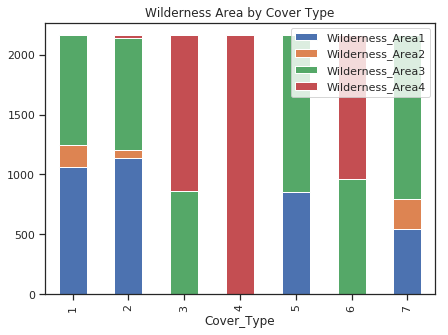

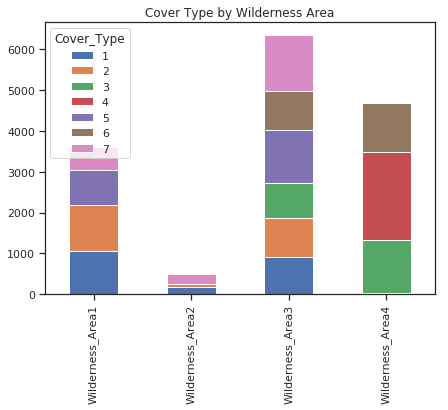

In [0]:
# Group wilderness by Cover Type
features = dataset.columns.tolist()
wd_binary = filter(lambda k: 'Wilderness' in k, np.array(features))
covergroup = dataset[wd_binary].groupby(dataset['Cover_Type']).sum()
covergroup.plot(kind='bar', stacked=True, figsize=(7,5), title='Wilderness Area by Cover Type')

covergroup.T.plot(kind='bar', stacked=True, figsize=(7,5), title='Cover Type by Wilderness Area')

### Models 

In this report, we evaluate a broad spectrum of different machine learning techniques to evaluate which perform the best on testing data using metrics such as log-loss, AUC, and f1-score.  The team selects this set of models after conducting grid search and learning from iterations of trials. 

We will use dimensionality reduction techniques such as principal component analysis (PCA) to reduce the number of features in our model to improve model robustness and reduce issues of multi-collinearity. We will perform feature engineering such as transforming skewed data with log and power transformations and by combining features to create new, derived features for our analysis. We will also employ model optimization techniques such as cross-validation, bagging, boosting, random initialization, and grid search to select optimal hyper-parameters.

![alt text](https://raw.githubusercontent.com/wcex1994/hailey_profile/master/machine_learning/Analysis%20Flow.jpg)



```
# This is formatted as code
```

**Original Dataset Run:**

To better understand what features are adding most information to the classification, we run a DecisionTree classifier using information gain as the criteria by which to process the standard feature set. The feature importance confirms our findings from EDA that 'Elevation' is the most information feature related to classification. It also shows that there is not much information gained from many of the soil type features. The model performance is at 78.5% accuracy, with the confusion matrix indicating that most confusions are observed between cover types 1 and 2 followed by cover types 3 and 6. This indicates we need to use feature selection/engineering techniques to come up with our best set of parameters that can help improve the accuracy of our predictions.

------- Decision Tree Classifier-----------
Accuracy: 0.7857142857142857 F1_Score: 0.7858138907582553


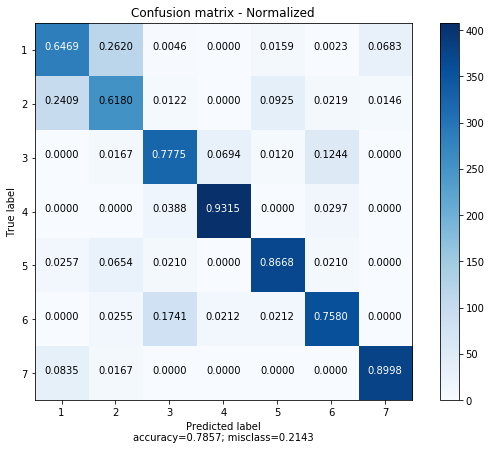

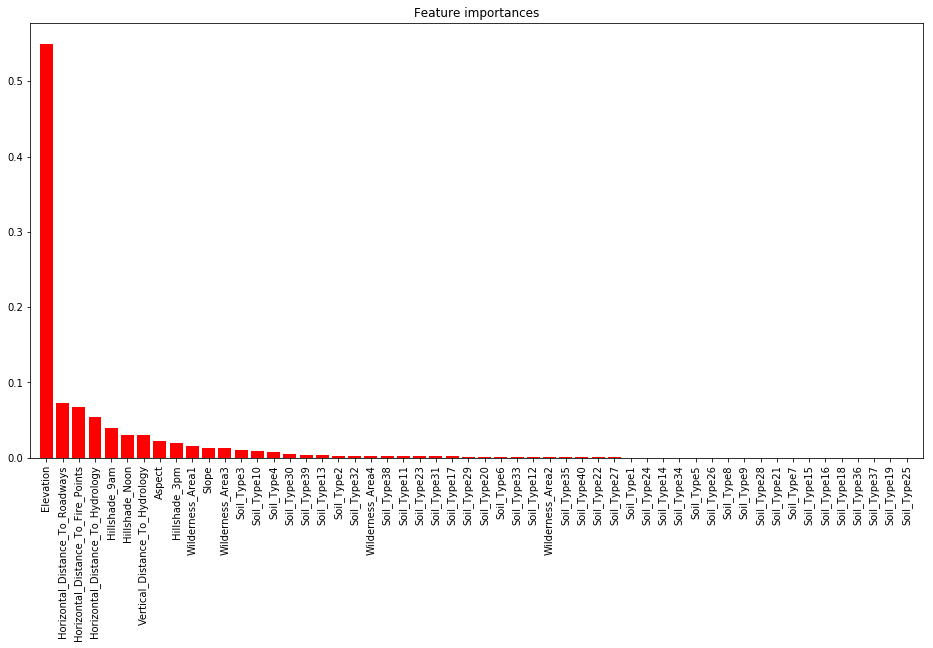

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix',
                          cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    if normalize:
      title = '{} - Normalized'.format(title)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)#, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def DT_classifier(X,Y,X1,Y1):
    dt = DecisionTreeClassifier(criterion='entropy', random_state=seed)
    dt.fit(X, Y)
    y_pred = dt.predict(X1)
    
    print('------- Decision Tree Classifier-----------')
    print('Accuracy:', accuracy_score(Y1,y_pred), 'F1_Score:', f1_score(Y1,y_pred, average='weighted'))
    #print('Confusion Matrix:')
    #print(confusion_matrix(Y1, y_pred))
    plot_confusion_matrix(cm=confusion_matrix(Y1, y_pred),target_names=np.unique(dataset['Cover_Type']))
    
    return dt

def plot_feature_importance(cls, X, data):
  
    """
    Citiation:
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    ---------
    """
    importances = cls.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([cls.feature_importances_],
                 axis=0)
    names = [data.columns[i] for i in indices]

    plt.figure(figsize = (16, 8))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), names, rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()
  
def scale_and_model(scaler, pddata):
    # Scale down contnuous features
    continuous_ftrs = pddata.iloc[:,0:10]
    con_ftrs_minmax = scaler.fit_transform(continuous_ftrs)
    feature_set = np.concatenate((con_ftrs_minmax, pddata.iloc[:,10:pddata.shape[1]]), axis=1)
    new_pddata = pd.DataFrame(data=feature_set, columns= pddata.columns)

    # Split dataset
    X, X1, Y, Y1 = train_test_split(new_pddata.drop('Cover_Type', axis=1), pddata['Cover_Type'], 
                                    test_size=0.2, random_state=seed)

    dt = DT_classifier(X, Y, X1, Y1)
    plot_feature_importance (dt, X, new_pddata)
    
scale_and_model(RobustScaler(), dataset)

### Feature Engineering and Enhancement  

Intuitively, we believe that the features we have in the data set all have an influence in determining the forest cover type. Elevation, proximity to water (in terms of hydrology),  amount of sunlight (hill shade), angle of the sun (aspect), slope, type of soil, type of wilderness are all seemingly important in helping determine the cover type. Additionally man-made features like roadways and fire points could also give an indication of what type of forest cover dominates an area. However, based on our feature importance calculation and confusion matrix above, these features as they stand do not seem to be sufficient in helping accurately determine the forest cover type. This leads us to believe that we need to look at additional and possibly different representations of the given features. To come up with our best parameters for our model, we consider::

- Adding some commonly used topographic indices which could potentially be relevant to our model
- Transforming existing features to make the data more meaningful
- Reducing dimensionality using feature selection and other techniques such as PCA
- Adding interaction terms between features where appropriate and effective

We break down this approach separately by continuous and categorical features.









#### Continuous Features

We explore whether different transformations of variables (log, sqrt, polynomials, *etc.*) could improve accuracy and uncover that log/polynomials/sqrt transformations do not really have any impact on the performance of our base model.  We also look at combinations of variables, interactions between continuous and categorical features, and consider new features that may have a plausible impact on determining the forest cover type and improve generalization in the context of the relationship between cover  type and wild fires. Finally, we standardize all continuous variables using RobustScaler to account for outliers.


**Potential Influence of Solar Radiation**

Influence of solar radiation on site moisture can potentially have an impact of forest fires and hence might be an important feature to include in our model. We convert *Aspect* to better represent the potential influence of solar radiation ("PSR") on site moisture conditions using the formula:  

$PSR = (\cos (\theta - 225) * {\pi}/180)$ where $\theta$ is the aspect in degrees

[ref: https://www.mdpi.com/1999-4907/9/3/130/pdf]

**Distance to Hydrology**

We combine the horizontal distance to hydrology and vertical distance to hydrology to represent the diagonal distance to hydrology using the formula:

$DistanceToHydrology = \sqrt{(HorizontalDistanceToHydrology)^2 + (VerticalDistanceToHydrology)^2}$

We use *distance to hydrology* in lieu of the horizontal and vertical distances to hydrology

**Topographic Wetness Index**

We believe that surface water can potentially have an impact on the forest canopy. Surface water is influenced by the topography of the terrain. The Topographic Wetness Index ("TWI")  has been designed based on the assumption that water movement is controlled by the topography of the slopes. TWI is defined as $TWI=\ln ({\alpha}/{\tan\beta})$ where $\alpha$ is the local upslope area draining through a certain point per contour length 
and $\tan\beta$ is the slope angle at the point. TWI is often used to describe spatial distribution of soil moisture and surface saturation of water and has often shown good correlation with soil moisture and depth to ground water. [ref: https://www.mdpi.com/1999-4907/9/3/130/pdf]

We tried to approximate a topographic wetness index for our model using hydrology and slope based on the data provided in this data set. 
Our value of TWI is calculated using the formula:

$TWI =  DistanceToHydrology * Slope$

**Aspect**

An object's cardinal direction, *e.g.*, North, South, South East, *etc.* is specified as the horizontal angle that the object makes with true North.  Since North serves as our reference direction, it is represented by $0^{\circ}$. $90{^{\circ}}$ would represent East. 
[ref: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-aspect-works.htm]

![alt text](https://c.tadst.com/gfx/750x500/horizontal-coordinate-system.png?1 "Aspect with reference to true North")

We converted aspect from a continuous variable in [0,360] to a one hot encoded categorical variable representing one of the eight cardinal directions. For example, if the aspect in degrees is between $22.5^{\circ}$ and $67.5^{\circ}$, the cardinal direction is North East. Similarly if the aspect in degrees is between $337.5^{\circ}$ and $22.5^{\circ}$, then the cardinal direction is North.


**HillShade**

The amount of sunlight that falls on an area is what determines hillshade. It is usually represented as 
a value between 0 and 255 with 0 indicating no light and 255 indicating full light. From our interview with an expert in agricultural consulting we gathered that hillshade is an important factor in determining cover type in a given area and that sun exposure in the first half of the day has more influence than hillshade at 3PM. We consider the following features for hillshade in lieu of these three native features:

- Avg_Hillshade: mean of hillshade values at 9AM, noon and 3PM
- MeanMorn_HS: mean of hillshade at 9AM and noon
- Delta1_HS: difference in morning hillshade (difference of hillshade at 9AM and noon standardized by hillshade at noon)
- Delta2_HS: difference in afternoon hillshade (difference of hillshade at 3PM and noon standardized by hillshade at noon)
- MeanDelta_HS: mean of delta1 and delta2

**Net Vertical Distance- Elevation and Hydrology**

Instead of relying just on elevation, we consider a net vertical distance combining elevation and
vertical distance to hydrology. When vertical distance to hydrology is negative we add this distance to
elevation and when positive, we subtract this distance from elevation. This feature shows a larger separation of classes than revealed by relying on elevation alone. 

Please refer to section [1.1. of appendix] to see a visualization of the improvement in class separation

**Maximum/Minimum Distance between Man-made Access Points**

Among the wilderness types we have, we notice that some wilderness have easy access to people while others are completely remote and secluded from human access.  In the given data set, distances to roadways and fire points are the only two features that directly quantify how much human interactions these forests have.  Since both these are specified as horizontal distances we look at the maximum and minimum distances between these human access points as they may be plausible indicators for forest cover types.

#### Categorical Variable - Soil Type

Soil types are important in determining how much ground water and surface run a forest can have. The data set indicated 40 varieties of soil defined by description and family. Family classifications are based on chemical properties, depth, mineralogy, salt and organic matter content, among others.  [ref: http://www.library.arizona.edu/exhibits/swetc/azso/body.1_div.6.html]  From the feature importance graph above we see that while some soil types are found in many forest covers (*e.g.*, soil type 10) and are important
in helping with cover type classification (e.g. soil types 3,10, 4, *etc.*), a few are insignificant in providing good information for classification (*e.g.*, Soil Types 37, 19, 25).
Soil Types 7 and 15 do not seem to have any information in them. We look at two different techniques to reduce the dimensionality of this feature from 40.

- Technique 1: Aggregate the 40 types into a different set of categories based on soil warmth and texture (*e.g.*, extremely bouldery, rubbly, stony, very stoney, *etc.*)

- Technique 2: Perform Principle Component Analysis (PCA) on the 40 soil type features. An initial  cumulative sum of explained variances shows that the first 25 components explained about 98% of the variance. L1 regularization also points to  25 PCA components. 

Our initial modeling gives better performance of PCA with 25 components than with Technique 1. So we use the dimensions resulting from Technique 2, *i.e.* PCA for our modeling. 

Please refer to sections [2 in Appendix ] for details on our analysis with both these techniques.

Accuracy: 0.8644179894179894
F1_Score: 0.8626560601992441


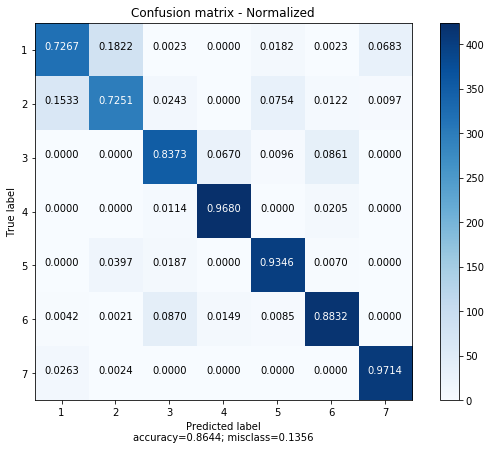

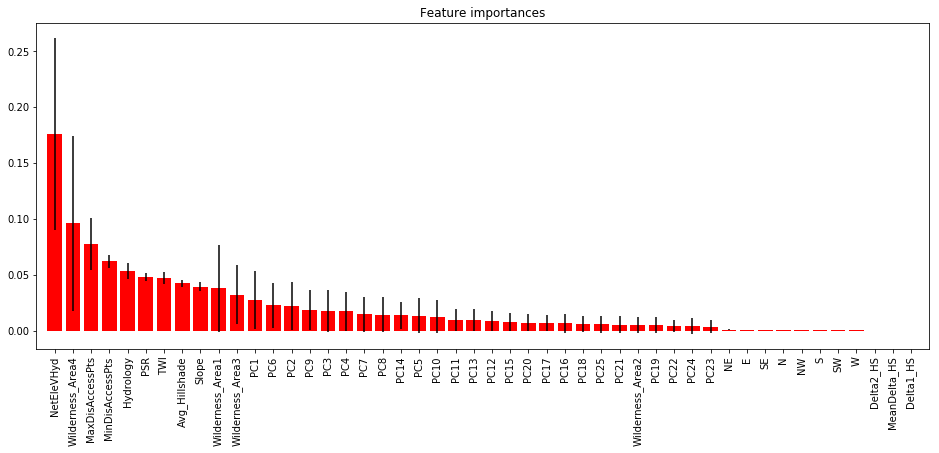

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Get all other continuous features and standardize and normalize them
def get_continuous_features(data, cols):
    """
    Returns a standardized dataframe for the columns provided
    """
    con_ftrs = data[cols]
    con_ftrs = RobustScaler().fit_transform(con_ftrs)
    con_ftrs_df = pd.DataFrame(data=con_ftrs, columns=cols)
    return con_ftrs_df
  
def create_aspect(pddata):
    """
    converts aspect to a dataframe of cardinal directions
    """
    new_aspect = np.zeros((pddata.shape[0], 8), dtype=int)
    columns = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

    for i in dataset.iloc[:, 1]:
        if pddata.iloc[i, 1] > 359:
            pddata.iloc[i, 1] = pddata.iloc[i, 1] - 360
        
        idx = int((pddata.iloc[i, 1] - 22.5)/45) + 1 if pddata.iloc[i, 1] > 0 else 0
        if idx == 8 : idx = 0
        new_aspect[i, idx] = 1

    #Create a new dataframe with 8 columns for Aspect based on directions
    aspect_dir = pd.DataFrame(data=new_aspect, columns= columns)
    return aspect_dir
  
def run_ensemble(data, lbl):
    model = ExtraTreesClassifier(n_estimators=250, criterion='entropy', random_state=seed)
    X, X1, Y, Y1 = train_test_split(
        data, lbl, test_size=0.2, random_state=seed)
    
    m1 = model.fit(X, Y)  
    y_pred = m1.predict(X1)
    f1 = metrics.f1_score(y_true=Y1.astype(int), y_pred=y_pred, average='weighted')
    print('Accuracy:', accuracy_score(Y1,y_pred))
    print('F1_Score:', f1_score(Y1,y_pred, average='weighted'))
    #print('Confusion Matrix:')
    #print(confusion_matrix(Y1, y_pred))
    plot_confusion_matrix(cm=confusion_matrix(Y1, y_pred),target_names=np.unique(dataset['Cover_Type']))
    plot_rf_feature_importance(model, X, data)
    
def plot_rf_feature_importance(cls, X, data):
    importances = cls.feature_importances_
    std = np.std([tree.feature_importances_ for tree in cls.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    names = [data.columns[i] for i in indices]
    
    plt.figure(figsize=(16,6))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), names, rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

def engr_new_features(data):
    """
    Adds all the new continuous features into a new dataframe
    """
    new_data = data.copy()
    
    ##-----Adding distance features
    #Net vertical distance - Elevation and Vertical Hydrology
    new_data['NetEleVHyd'] = data['Elevation'] - data['Vertical_Distance_To_Hydrology']
    
    #Distance to Hydrology
    new_data['Hydrology'] = (new_data['Horizontal_Distance_To_Hydrology']**2 \
                    + new_data['Vertical_Distance_To_Hydrology']**2) ** 0.5
    
    #Max Distance between Access Points
    new_data['MaxDisAccessPts'] = data['Horizontal_Distance_To_Fire_Points'] \
                    + data['Horizontal_Distance_To_Roadways']
    
    #Min Distance between Access Points
    new_data['MinDisAccessPts'] = (data['Horizontal_Distance_To_Fire_Points'] \
                    - data['Horizontal_Distance_To_Roadways'])
    
    ##-----Adding Hillshade features
    new_data['Avg_Hillshade'] = data[['Hillshade_9am','Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
    new_data['MeanMorn_HS'] = data[['Hillshade_9am','Hillshade_Noon']].mean(axis=1)
    new_data['Delta1_HS'] = (data['Hillshade_Noon']-data['Hillshade_9am']).std(axis=0)
    new_data['Delta2_HS'] = (data['Hillshade_Noon']-data['Hillshade_3pm']).std(axis=0)
    new_data['MeanDelta_HS'] = new_data[['Delta1_HS','Delta2_HS']].mean(axis=1)
    
    ##-----Additional Topological Features
    # Potential Influence of Solar Ration (PSR)
    new_data['PSR'] = np.cos((data['Aspect'] - 255) * np.pi/180) 
    
    # Topological Water Index
    new_data['TWI'] = new_data["Hydrology"] * dataset["Slope"]
    
    return new_data
  
def add_pca_soiltypes(data, cols):
  new_dataset = engr_new_features(dataset)
  
  # Get Soil Types
  soil_pca = data.loc[:,'Soil_Type1':'Soil_Type40']

  pca_comp = 25 #picked to maximize variance
  pca_2d = PCA(n_components=pca_comp)
  PCs_2d = pd.DataFrame(pca_2d.fit_transform(soil_pca))
  columns = []
  for i in range(1,pca_comp+1,1):
      columns.append('PC{}'.format(i))

  PCs_2d.columns = columns

  aspect_dir = create_aspect(data)
  con_ftrs = get_continuous_features(new_dataset, cols)
  con_ftrs2 = get_continuous_features(PCs_2d, PCs_2d.columns)
  ftrs_c_data = pd.concat([con_ftrs, aspect_dir, 
                           data.iloc[:, 10:14],
                           con_ftrs2], axis=1)

  run_ensemble(ftrs_c_data, data['Cover_Type'])
  return ftrs_c_data

new_ftr_set = add_pca_soiltypes(dataset, ['NetEleVHyd', 'Hydrology', 
                                                  'MaxDisAccessPts', 'MinDisAccessPts', 
                                                  'Slope','PSR', 'TWI', 'Avg_Hillshade',
                                                  'Delta1_HS', 'Delta2_HS','MeanDelta_HS'])

#### Interaction Terms

We also experiment with various interaction terms among the standard feature set.  Of particular interest are interactions among points such as roadways and fire points and Elevation and the indicators for specific wilderness areas.  We reason this last set of categorical variables are important for capturing variation in properties unique to sub-regions of the park that may influence cover type but are not captured by the other available set of features.  For example, each wilderness area has different 
histories of fires (planned or wild), different restrictions on human activity (*e.g.*, motor vehicles, foraging, skiing, camping, and camp fires), different levels of usage by the public, and different neighboring towns/industries.  Below we examine whether we can engineer these variables to improve classification.


Accuracy: 0.8809523809523809
F1_Score: 0.8798024046637705


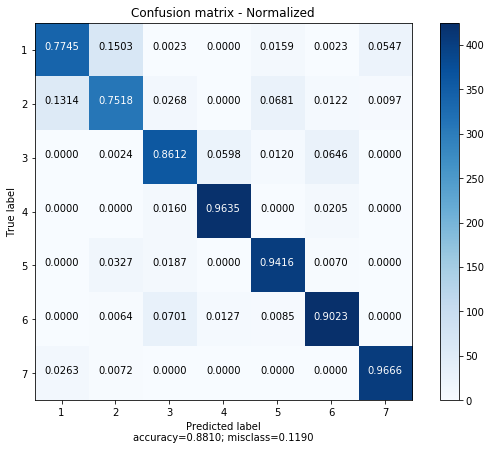

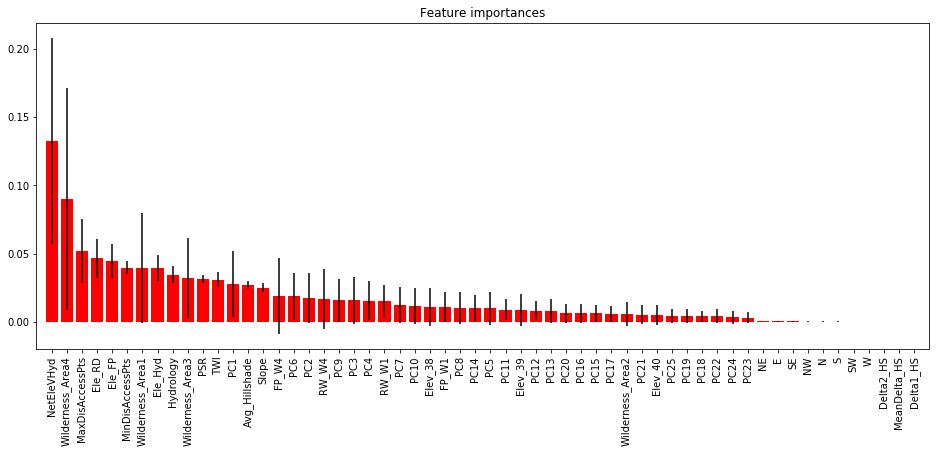

,NetEleVHyd,Hydrology,MaxDisAccessPts,MinDisAccessPts,Slope,PSR,TWI,Avg_Hillshade,Delta1_HS,Delta2_HS,MeanDelta_HS,N,NE,E,SE,S,SW,W,NW,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,Ele_RD,Ele_FP,Ele_Hyd,RW_W1,RW_W4,FP_W1,FP_W4,Elev_38,Elev_39,Elev_40
0,-0.134228,0.252905,1.759299,4.779041,-1.000000,-4.043891e-01,-0.423466,0.380952,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,-3.484310,14.687389,1.106957,0.657095,0.434072,0.329544,-0.219868,0.116653,0.096255,-0.073813,-4.458990e-14,-1.118832e-13,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.651230,0.645223,0.663818,6.748078e-01,6.717500e-01,6.784806e-01,6.818108e-01,0.114684,-0.855440,-0.054194,-0.535193,-0.0,3.992052,0.0,-0.0,-0.0,-0.0
1,-0.134228,0.085870,1.687584,4.832656,-1.083333,-4.315993e-01,-0.496563,0.460317,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,-3.484310,14.687389,1.106957,0.657095,0.434072,0.329544,-0.219868,0.116653,0.096255,-0.073813,4.434183e-15,-3.365134e-13,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.651230,0.645223,0.663818,6.748078e-01,6.717500e-01,6.784806e-01,6.818108e-01,0.136826,-0.878791,-0.019108,-0.614874,-0.0,3.949136,0.0,-0.0,-0.0,-0.0
2,0.057718,0.317550,2.794642,2.481722,-0.500000,1.889673e-16,-0.066593,0.476190,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0.786121,0.566928,0.155625,0.070274,0.049325,-0.019250,0.041226,-0.358884,-0.323699,0.266460,-3.367308e-01,3.625280e-01,0.791353,1.602527,2.086843,2.959729,3.83299,3.942560,15.196354,95.707491,-13.772399,-1.107152e+01,-8.072092e+00,-6.407134e+00,-5.804173e+00,0.088408,0.276177,0.022682,1.237716,0.0,3.866481,0.0,0.0,0.0,0.0
3,-0.038926,0.293780,2.794642,2.627945,0.250000,2.252880e-01,0.427433,0.333333,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,0,0,0,-0.285156,-0.332733,-0.602857,-1.224272,-3.996549,-60.091108,-3.724672,2.460337,1.429911,-0.900780,6.676187e-01,-6.693694e-01,-0.312451,-0.477024,-0.251184,-0.234169,-0.07550,-0.066672,-0.007750,-0.007396,-0.007206,-3.337810e-13,-1.212668e-13,-1.901578e-13,-3.380244e-13,0.053396,0.178509,0.013317,1.177955,0.0,3.938009,0.0,0.0,0.0,0.0
4,-0.134228,-0.129064,1.666151,4.788790,-1.083333,-3.639479e-01,-0.521254,0.428571,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,-3.484310,14.687389,1.106957,0.657095,0.434072,0.329544,-0.219868,0.116653,0.096255,-0.073813,3.039741e-13,1.466867e-12,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.651230,0.645223,0.663818,6.748078e-01,6.717500e-01,6.784806e-01,6.818108e-01,0.132460,-0.842584,0.027834,-0.614210,-0.0,3.907014,0.0,-0.0,-0.0,-0.0


In [0]:
def interaction(data):
    ftr_set = data.copy()
    cont_ftrs = get_continuous_features(dataset, ['Elevation', 
                                        'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
                                                 'Aspect', 'Slope'])
    ftr_set['Ele_RD'] = cont_ftrs['Elevation']* cont_ftrs['Horizontal_Distance_To_Roadways']
    ftr_set['Ele_FP'] = cont_ftrs['Elevation']* cont_ftrs['Horizontal_Distance_To_Fire_Points']
    ftr_set['Ele_Hyd'] = cont_ftrs['Elevation'] * data['Hydrology']
    ftr_set['RW_W1'] = cont_ftrs['Horizontal_Distance_To_Roadways'] * data['Wilderness_Area1']
    ftr_set['RW_W4'] = cont_ftrs['Horizontal_Distance_To_Roadways'] * data['Wilderness_Area4']
    ftr_set['FP_W1'] = cont_ftrs['Horizontal_Distance_To_Fire_Points'] * data['Wilderness_Area1']
    ftr_set['FP_W4'] = cont_ftrs['Horizontal_Distance_To_Fire_Points'] * data['Wilderness_Area4']
    ftr_set['Elev_38'] = cont_ftrs['Elevation']* pd.to_numeric(dataset['Soil_Type38'])
    ftr_set['Elev_39'] = cont_ftrs['Elevation']* pd.to_numeric(dataset['Soil_Type39'])
    ftr_set['Elev_40'] = cont_ftrs['Elevation']* pd.to_numeric(dataset['Soil_Type40'])
    
    run_ensemble(ftr_set, dataset['Cover_Type'])
    
    return ftr_set
  
final_ftr_set = interaction(new_ftr_set)
final_ftr_set.head()

From the feature importance graph above we see that most of the features we have added to our model have some significance in determining forst cover type. The features at the tail end dont seem to add value. So we drop some of them from our feature set.

In [0]:
def drop_columns(data, cols):
  for col in cols:
    if col in data.columns:
      data.drop(col, inplace=True, axis=1)

drop_columns(final_ftr_set, ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
final_ftr_set.head()

,NetEleVHyd,Hydrology,MaxDisAccessPts,MinDisAccessPts,Slope,PSR,TWI,Avg_Hillshade,Delta1_HS,Delta2_HS,MeanDelta_HS,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,Ele_RD,Ele_FP,Ele_Hyd,RW_W1,RW_W4,FP_W1,FP_W4,Elev_38,Elev_39,Elev_40
0,-0.134228,0.252905,1.759299,4.779041,-1.000000,-4.043891e-01,-0.423466,0.380952,0.0,0.0,0.0,1,0,0,0,-3.484310,14.687389,1.106957,0.657095,0.434072,0.329544,-0.219868,0.116653,0.096255,-0.073813,-4.458990e-14,-1.118832e-13,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.651230,0.645223,0.663818,6.748078e-01,6.717500e-01,6.784806e-01,6.818108e-01,0.114684,-0.855440,-0.054194,-0.535193,-0.0,3.992052,0.0,-0.0,-0.0,-0.0
1,-0.134228,0.085870,1.687584,4.832656,-1.083333,-4.315993e-01,-0.496563,0.460317,0.0,0.0,0.0,1,0,0,0,-3.484310,14.687389,1.106957,0.657095,0.434072,0.329544,-0.219868,0.116653,0.096255,-0.073813,4.434183e-15,-3.365134e-13,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.651230,0.645223,0.663818,6.748078e-01,6.717500e-01,6.784806e-01,6.818108e-01,0.136826,-0.878791,-0.019108,-0.614874,-0.0,3.949136,0.0,-0.0,-0.0,-0.0
2,0.057718,0.317550,2.794642,2.481722,-0.500000,1.889673e-16,-0.066593,0.476190,0.0,0.0,0.0,1,0,0,0,0.786121,0.566928,0.155625,0.070274,0.049325,-0.019250,0.041226,-0.358884,-0.323699,0.266460,-3.367308e-01,3.625280e-01,0.791353,1.602527,2.086843,2.959729,3.83299,3.942560,15.196354,95.707491,-13.772399,-1.107152e+01,-8.072092e+00,-6.407134e+00,-5.804173e+00,0.088408,0.276177,0.022682,1.237716,0.0,3.866481,0.0,0.0,0.0,0.0
3,-0.038926,0.293780,2.794642,2.627945,0.250000,2.252880e-01,0.427433,0.333333,0.0,0.0,0.0,1,0,0,0,-0.285156,-0.332733,-0.602857,-1.224272,-3.996549,-60.091108,-3.724672,2.460337,1.429911,-0.900780,6.676187e-01,-6.693694e-01,-0.312451,-0.477024,-0.251184,-0.234169,-0.07550,-0.066672,-0.007750,-0.007396,-0.007206,-3.337810e-13,-1.212668e-13,-1.901578e-13,-3.380244e-13,0.053396,0.178509,0.013317,1.177955,0.0,3.938009,0.0,0.0,0.0,0.0
4,-0.134228,-0.129064,1.666151,4.788790,-1.083333,-3.639479e-01,-0.521254,0.428571,0.0,0.0,0.0,1,0,0,0,-3.484310,14.687389,1.106957,0.657095,0.434072,0.329544,-0.219868,0.116653,0.096255,-0.073813,3.039741e-13,1.466867e-12,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.651230,0.645223,0.663818,6.748078e-01,6.717500e-01,6.784806e-01,6.818108e-01,0.132460,-0.842584,0.027834,-0.614210,-0.0,3.907014,0.0,-0.0,-0.0,-0.0


## Final Model Selection and Tuning

H20 was used for final model selection and tuning.  H2O is an open source, java-based, in-memory, distributed, fast, and scalable machine learning and predictive analytics [platform](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html). First H20 AutoML was used on the final feature set to help determine which models were performing the best from among the following models:

*   Deep Learning Net
*   Gradient Boosted Machine (GBM)
*   Generalized Linear Model (GLM)
*   Distributed Random Forest (DRF)
*   XGBoost
*   Support Vector Machine (SVM)
*   Stacked Ensembles

Using the AutoML we identified GBM as the best model to use for this use case.  (see Appendix)

After having picked a final model algorithm, we began tuning the GBM using Grid Search Techniques to develop our final model. 



### Gradient Boosted Machine (GBM) Tuning

First we train a baseline GBM using default parameters.  Then we use a GridSearch to determine optimal tree depth for our final model.  Using these optimal tree depth parameters, we tune our final model using a randomized (stochastic) hyperparameter search ("[RandomDiscrete](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html?highlight=randomdiscrete#grid-search-in-python)"). The performance of the final model is determined using validation and holdout (test) data. 

**Decision Trees**

Strength | Weaknesses    
--- | ---
Non-Linear | Poor Accuracy
Robust to Collinearity |
Robust to Missing Values |
Simple to Explain |
Fast to Train |
Fast to Score |

  

---


  
**Improved Decision Trees**

Random Forest | Gradient Boosted Machines (GBM)
---|---
Bootstrap Aggregation | Boosting
Fit many trees and average | Fit consecutive trees and solve net error
  
  

---



**Random Forest Overview**

Conceptual | Practical
---|---
Combine multipe decision trees on random samples | Few Parameters (easy to use)
Samples rows/columns randomly | Robust w/ Competitive Accuracy
Reduce variance with less bias | Slow to score, Lack of Transpency



---


**Gradient Boosted Machines**

Conceptual | Practical
---|---
ensemble of weak learners | Robust, One of best models
fit consecutive trees and solve for net loss of prior | Overfitting, need good stopping point
Results of new trees are applied to entire solution | Senstive to noise/Extreme values
| Several hyperperameters to tune

In [0]:
#Install H2O library and requirements

!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [0]:
'''
References: 

(1) https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb
(2) https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/gbm-randomforest/GBM_RandomForest_in_H2O.pdf

'''
import h2o
import numpy as np
import math
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(nthreads=-1)
# h2o.init(nthreads=-1, strict_version_check=True)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,17 mins 37 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_unknownUser_qij3x0
H2O cluster total nodes:,1
H2O cluster free memory:,2.913 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"


In [0]:
data = final_ftr_set.copy()
data = pd.concat([data, dataset['Cover_Type']], axis=1, join='inner')

df = h2o.H2OFrame(data)

print(df.dim)
print(df.head)

Parse progress: |█████████████████████████████████████████████████████████| 100%
[15120, 51]


NetEleVHyd,Hydrology,MaxDisAccessPts,MinDisAccessPts,Slope,PSR,TWI,Avg_Hillshade,Delta1_HS,Delta2_HS,MeanDelta_HS,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,Ele_RD,Ele_FP,Ele_Hyd,RW_W1,RW_W4,FP_W1,FP_W4,Elev_38,Elev_39,Elev_40,Cover_Type
-0.134228,0.252905,1.7593,4.77904,-1,-0.404389,-0.423466,0.380952,0,0,0,1,0,0,0,-3.48431,14.6874,1.10696,0.657095,0.434072,0.329544,-0.219868,0.116653,0.0962554,-0.0738131,3.49246e-13,-3.0448e-13,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.65123,0.645223,0.663818,0.674808,0.67175,0.678481,0.681811,0.114684,-0.85544,-0.0541939,-0.535193,0,3.99205,0,0,0,0,5
-0.134228,0.0858698,1.68758,4.83266,-1.08333,-0.431599,-0.496563,0.460317,0,0,0,1,0,0,0,-3.48431,14.6874,1.10696,0.657095,0.434072,0.329544,-0.219868,0.116653,0.0962554,-0.0738131,2.10081e-14,1.21956e-13,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.65123,0.645223,0.663818,0.674808,0.67175,0.678481,0.681811,0.136826,-0.878791,-0.0191084,-0.614874,0,3.94914,0,0,0,0,5
0.0577181,0.31755,2.79464,2.48172,-0.5,1.88967e-16,-0.0665933,0.47619,0,0,0,1,0,0,0,0.786121,0.566928,0.155625,0.0702737,0.0493251,-0.0192496,0.0412264,-0.358884,-0.323699,0.26646,-0.336731,0.362528,0.791353,1.60253,2.08684,2.95973,3.83299,3.94256,15.1964,95.7075,-13.7724,-11.0715,-8.07209,-6.40713,-5.80417,0.0884083,0.276177,0.0226822,1.23772,0,3.86648,0,0,0,0,2
-0.0389262,0.29378,2.79464,2.62794,0.25,0.225288,0.427433,0.333333,0,0,0,1,0,0,0,-0.285156,-0.332733,-0.602857,-1.22427,-3.99655,-60.0911,-3.72467,2.46034,1.42991,-0.90078,0.667619,-0.669369,-0.312451,-0.477024,-0.251184,-0.234169,-0.0755003,-0.0666724,-0.00775003,-0.00739616,-0.00720615,-3.31882e-13,-1.42443e-13,-2.14897e-13,-1.81819e-13,0.0533963,0.178509,0.013317,1.17795,0,3.93801,0,0,0,0,2
-0.134228,-0.129064,1.66615,4.78879,-1.08333,-0.363948,-0.521254,0.428571,0,0,0,1,0,0,0,-3.48431,14.6874,1.10696,0.657095,0.434072,0.329544,-0.219868,0.116653,0.0962554,-0.0738131,-1.73646e-13,1.53233e-12,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.65123,0.645223,0.663818,0.674808,0.67175,0.678481,0.681811,0.13246,-0.842584,0.0278339,-0.61421,0,3.90701,0,0,0,0,5
-0.136913,0.407061,1.4745,4.93745,-0.75,-0.0904375,-0.208613,0.47619,0,0,0,1,0,0,0,-3.48431,14.6874,1.10696,0.657095,0.434072,0.329544,-0.219868,0.116653,0.0962554,-0.0738131,8.98403e-13,-2.29785e-12,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.65123,0.645223,0.663818,0.674808,0.67175,0.678481,0.681811,0.197084,-0.901823,-0.0967329,-0.829349,0,3.79495,0,0,0,0,2
-0.127517,0.296728,1.80052,4.66044,-0.666667,-0.363948,-0.190209,0.126984,0,0,0,1,0,0,0,-3.48431,14.6874,1.10696,0.657095,0.434072,0.329544,-0.219868,0.116653,0.0962554,-0.0738131,-1.02101e-12,1.15852e-12,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.65123,0.645223,0.663818,0.674808,0.67175,0.678481,0.681811,0.090953,-0.796938,-0.0595087,-0.453519,0,3.97377,0,0,0,0,5
-0.131544,0.165976,1.76425,4.68643,-0.916667,-0.391835,-0.389529,0.301587,0,0,0,1,0,0,0,-3.48431,14.6874,1.10696,0.657095,0.434072,0.329544,-0.219868,0.116653,0.0962554,-0.0738131,8.01099e-14,-1.99112e-13,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.65123,0.645223,0.663818,0.674808,0.67175,0.678481,0.681811,0.0996207,-0.797903,-0.0335144,-0.49336,0,3.95152,0,0,0,0,5
-0.181208,0.210875,1.80917,4.62388,-0.5,-0.363948,-0.121737,0,0,0,0,1,0,0,0,-3.48431,14.6874,1.10696,0.657095,0.434072,0.329544,-0.219868,0.116653,0.0962554,-0.0738131,-7.1164e-15,2.39505e-13,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.65123,0.645223,0.663818,0.674808,0.67175,0.678481,0.681811,0.080037,-0.735126,-0.0391046,-0.431607,0,3.96424,0,0,0,0,5
-0.127517,0.213779,1.79104,4.63688,-0.416667,-0.444997,-0.0685742,-0.0952381,0,0,0,1,0,0,0,-3.48431,14.6874,1.10696,0.657095,0.434072,0.329544,-0.219868,0.116653,0.0962554,-0.0738131,-2.58004e-13,1.32989e-12,0.122934,0.207862,0.334532,0.

<bound method H2OFrame.head of >


In [0]:
response = 'Cover_Type'
df[response] = df[response].asfactor()

predictors = df.columns
del(predictors[47])

(list(enumerate(predictors)))

[(0, 'NetEleVHyd'),
 (1, 'Hydrology'),
 (2, 'MaxDisAccessPts'),
 (3, 'MinDisAccessPts'),
 (4, 'Slope'),
 (5, 'PSR'),
 (6, 'TWI'),
 (7, 'Avg_Hillshade'),
 (8, 'Delta1_HS'),
 (9, 'Delta2_HS'),
 (10, 'MeanDelta_HS'),
 (11, 'Wilderness_Area1'),
 (12, 'Wilderness_Area2'),
 (13, 'Wilderness_Area3'),
 (14, 'Wilderness_Area4'),
 (15, 'PC1'),
 (16, 'PC2'),
 (17, 'PC3'),
 (18, 'PC4'),
 (19, 'PC5'),
 (20, 'PC6'),
 (21, 'PC7'),
 (22, 'PC8'),
 (23, 'PC9'),
 (24, 'PC10'),
 (25, 'PC11'),
 (26, 'PC12'),
 (27, 'PC13'),
 (28, 'PC14'),
 (29, 'PC15'),
 (30, 'PC16'),
 (31, 'PC17'),
 (32, 'PC18'),
 (33, 'PC19'),
 (34, 'PC20'),
 (35, 'PC21'),
 (36, 'PC22'),
 (37, 'PC23'),
 (38, 'PC24'),
 (39, 'PC25'),
 (40, 'Ele_RD'),
 (41, 'Ele_FP'),
 (42, 'Ele_Hyd'),
 (43, 'RW_W1'),
 (44, 'RW_W4'),
 (45, 'FP_W1'),
 (46, 'FP_W4'),
 (47, 'Elev_39'),
 (48, 'Elev_40'),
 (49, 'Cover_Type')]

In [0]:
#splitting final feature set into training, validation and testing (holdout) sets

train, valid, test = df.split_frame(
    ratios=[0.6,0.2], 
    seed=seed, 
    destination_frames=['train.hex','valid.hex','test.hex']
)

#### Baseline GBM Model Performance

The baseline GBM model give us an accuracy of: 0.8271107 using default parameters.  These parameters will have to be tuned to give us accuracy comprable to the AutoML model.

In [0]:
#Using default parameter values
gbm = H2OGradientBoostingEstimator()
gbm.train(x=predictors, y=response, training_frame=train)

## Show a detailed model summary
print(gbm)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1564949275819_6

Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,50.0,350.0,125237.0,5.0,5.0,5.0,10.0,32.0,23.797142




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.09505976636022752
RMSE: 0.3083176387432732
LogLoss: 0.31775336382798736
Mean Per-Class Error: 0.09618232777507132
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,6,7,Error,Rate
1116.0,105.0,1.0,0.0,25.0,1.0,45.0,0.1368910,"177 / 1,293"
190.0,933.0,23.0,0.0,100.0,28.0,4.0,0.2699531,"345 / 1,278"
0.0,4.0,1126.0,27.0,7.0,114.0,0.0,0.1189358,"152 / 1,278"
0.0,0.0,7.0,1270.0,0.0,4.0,0.0,0.0085870,"11 / 1,281"
0.0,27.0,15.0,0.0,1280.0,12.0,0.0,0.0404798,"54 / 1,334"
0.0,7.0,71.0,14.0,14.0,1220.0,0.0,0.0799397,"106 / 1,326"
24.0,0.0,0.0,0.0,0.0,0.0,1274.0,0.0184900,"24 / 1,298"
1330.0,1076.0,1243.0,1311.0,1426.0,1379.0,1323.0,0.0956206,"869 / 9,088"


Top-7 Hit Ratios: 


k,hit_ratio
1,0.9043794
2,0.9875660
3,0.9980194
4,1.0
5,1.0
6,1.0
7,1.0


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
,2019-08-04 20:25:49,0.007 sec,0.0,0.8571429,1.9459101,0.859375
,2019-08-04 20:25:50,0.433 sec,1.0,0.8031441,1.6379772,0.2546215
,2019-08-04 20:25:50,0.849 sec,2.0,0.7559298,1.4357884,0.2535211
,2019-08-04 20:25:50,1.302 sec,3.0,0.7146739,1.2880678,0.2411972
,2019-08-04 20:25:51,1.723 sec,4.0,0.6777143,1.1708239,0.2391065
,2019-08-04 20:25:51,2.194 sec,5.0,0.6454397,1.0778815,0.2336048
,2019-08-04 20:25:52,2.541 sec,6.0,0.6163682,0.9985733,0.2281030
,2019-08-04 20:25:52,2.799 sec,7.0,0.5901055,0.9304673,0.2248019
,2019-08-04 20:25:52,3.111 sec,8.0,0.5677278,0.8747747,0.2186400
,2019-08-04 20:25:53,3.367 sec,9.0,0.5475030,0.8254792,0.2120379


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
NetEleVHyd,11753.7509766,1.0,0.4679230
PC1,1734.0437012,0.1475311,0.0690332
RW_W1,1382.3284912,0.1176074,0.0550312
MinDisAccessPts,803.5177612,0.0683627,0.0319885
Ele_RD,788.9283447,0.0671214,0.0314077
---,---,---,---
PC16,46.5254669,0.0039584,0.0018522
PC21,44.6007881,0.0037946,0.0017756
PC17,21.3070488,0.0018128,0.0008482
Wilderness_Area2,13.0993786,0.0011145,0.0005215



See the whole table with table.as_data_frame()



In [0]:
gbm.confusion_matrix(test)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,6,7,Error,Rate
322.0,61.0,0.0,0.0,12.0,0.0,30.0,0.2423529,103 / 425
93.0,273.0,6.0,0.0,67.0,13.0,5.0,0.4026258,184 / 457
0.0,2.0,334.0,16.0,10.0,62.0,0.0,0.2122642,90 / 424
0.0,0.0,5.0,411.0,0.0,13.0,0.0,0.0419580,18 / 429
0.0,17.0,11.0,0.0,356.0,8.0,0.0,0.0918367,36 / 392
0.0,4.0,49.0,11.0,2.0,355.0,0.0,0.1567696,66 / 421
17.0,0.0,0.0,0.0,0.0,0.0,408.0,0.04,17 / 425
432.0,357.0,405.0,438.0,447.0,451.0,443.0,0.1728893,"514 / 2,973"


In [0]:
gbm.varimp(use_pandas = True)

,variable,relative_importance,scaled_importance,percentage
0,NetEleVHyd,11753.750977,1.000000,0.467923
1,PC1,1734.043701,0.147531,0.069033
2,RW_W1,1382.328491,0.117607,0.055031
3,MinDisAccessPts,803.517761,0.068363,0.031988
4,Ele_RD,788.928345,0.067121,0.031408
5,MaxDisAccessPts,754.168152,0.064164,0.030024
6,Ele_FP,720.620239,0.061310,0.028688
7,TWI,696.871765,0.059289,0.027743
8,Ele_Hyd,684.794189,0.058262,0.027262
9,Hydrology,608.467896,0.051768,0.024223


In [0]:
gbm.summary().as_data_frame()

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,350.0,125237.0,5.0,5.0,5.0,10.0,32.0,23.797142


#### Baseline GBM Model Peformance with Cross-Validation

We use 4-fold crossvalidation to explore how variable the data is between folds.  The mean CV accuracy is 0.82798004 which is comparable to the results of the base model run without crossvalidation, meaning the data does not have a lot of variability and that our models should generalize well, assuming the scored data has similar variability.  

In [0]:

## Run cross-validation on the base model to see how variable the results are.
cv_gbm = H2OGradientBoostingEstimator(nfolds = 4, seed = seed)
cv_gbm.train(x = predictors, y = response, training_frame = train.rbind(valid))

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [0]:

## Show a detailed summary of the cross validation metrics
## This gives you an idea of the variance between the folds
cv_summary = cv_gbm.cross_validation_metrics_summary().as_data_frame()
print(cv_summary)


## Get the cross-validated logloss by scoring the combined holdout predictions.
perf_cv = cv_gbm.model_performance(xval=True)
print(perf_cv.logloss())

                                  mean  ...  cv_3_valid  cv_4_valid
0                 accuracy  0.82798004  ...  0.82049584   0.8226601
1                      err  0.17201994  ...  0.17950413   0.1773399
2                err_count       522.5  ...       543.0       540.0
3                  logloss  0.46378937  ...  0.46668792  0.46904755
4      max_per_class_error   0.4003755  ...  0.40617576  0.42857143
5  mean_per_class_accuracy   0.8272478  ...  0.82075256   0.8220984
6     mean_per_class_error   0.1727522  ...  0.17924747  0.17790166
7                      mse  0.14632283  ...    0.147992  0.14803885
8                       r2  0.96334904  ...    0.963333   0.9628274
9                     rmse  0.38250694  ...   0.3846973  0.38475817

[10 rows x 7 columns]
0.46381660739781955



#### Tuning Baseline Model with Gridsearch

Next, we train a GBM with a gridsearch. Early stopping will automatically tune the number of trees using the validation logloss. We set a low learning rate and use stochastic sampling of rows and columns to  improve generalization. The Gridsearch is based on a Cartesian search strategy that will cover the entire space of hyperperameter combinations. 

In [0]:
# test different tree depths (default = 5)
hyper_params = {'max_depth' : [4,6,8,12,16,20]} 

#Build initial GBM Model
gbm_grid = H2OGradientBoostingEstimator(
        ## more trees is better if the learning rate is small enough 
        ntrees=1000,
        ## setting learning_rate_annealing allows us to start with a 
        #bigger learning rate
        learn_rate=0.05,
        ## learning rate annealing: learning_rate shrinks by 1% after every tree 
        learn_rate_annealing = 0.99,
        ## sample 80% of rows per tree
        sample_rate = 0.8,
        ## sample 80% of columns per split
        col_sample_rate = 0.8,
        ## fix a random number generator seed for reproducibility
        seed = seed,
        ## score every 10 trees to make early stopping reproducible 
        score_tree_interval = 10, 
        ## early stopping once the validation logloss doesn't improve by at least 0.01% for 
        #5 consecutive scoring events
        stopping_rounds = 5,
        stopping_metric = "logloss",
        stopping_tolerance = 1e-4)

#Build grid search with previously made GBM and hyper parameters
# We use a cartesian search strategy to every combination is explored. 
grid = H2OGridSearch(gbm_grid,hyper_params,
                         grid_id = 'depth_grid',
                         search_criteria = {'strategy': "Cartesian"})


#Train grid search
grid.train(x=predictors, 
           y=response,
           training_frame = train,
           validation_frame = valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [0]:
sorted_grid = grid.get_grid(sort_by='logloss',decreasing=False)
print(sorted_grid)

max_depths = sorted_grid.sorted_metric_table()['max_depth'][0:5]
new_max = int(max(max_depths, key=int))
new_min = int(min(max_depths, key=int))

print("MaxDepth", new_max)
print("MinDepth", new_min)

    max_depth           model_ids              logloss
0          16  depth_grid_model_5  0.32773676224650045
1          12  depth_grid_model_4   0.3296810821690076
2          20  depth_grid_model_6  0.33270878048832386
3           8  depth_grid_model_3  0.35422895134456045
4           6  depth_grid_model_2  0.40576303241586664
5           4  depth_grid_model_1   0.5088158051122577

MaxDepth 20
MinDepth 6


The Cartesian Gridsearch has determined that the optimal tree depth for this GBM is between 6 and 20. We use this combination in our final Gridsearch, this time using the RandomDiscrete tuning strategy. As a result, 30 models will be built and rank-ordered based on the logloss metric.  The best model developed by this Gridsearch (model_id: final_grid_model_2) has a logloss score of 0.349472 which is comparable to the AutoML logloss score of 0.3486243.

In [0]:
# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
hyper_params_tune = {'max_depth' : list(range(new_min,new_max+1,1)),
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                'nbins': [2**x for x in range(4,11)],
                'nbins_cats': [2**x for x in range(4,13)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["Auto"]}
search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 800,  ## limit the runtime to 13 minutes
                   'max_models': 30,  ## build no more than 30 models
                   'seed' : seed,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "logloss",
                   'stopping_tolerance': 1e-3
                   }

In [0]:
gbm_final_grid = H2OGradientBoostingEstimator(distribution='multinomial',
                    ## more trees is better if the learning rate is small enough 
                    ntrees=1000,
                    ## since we have learning_rate_annealing, we can afford to start with a 
                    #bigger learning rate
                    learn_rate=0.05,
                    ## learning rate annealing: learning_rate shrinks by 1% after every tree 
                    learn_rate_annealing = 0.99,
                    ## score every 10 trees to make early stopping reproducible 
                    score_tree_interval = 10,
                    ## fix a random number generator seed for reproducibility
                    seed = seed,
                    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    #5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "logloss",
                    stopping_tolerance = 1e-4)
            
#Build grid search with previously made GBM and hyper parameters
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid',
                                    search_criteria = search_criteria_tune)
#Train grid search
final_grid.train(x=predictors, 
           y=response,
           ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
           max_runtime_secs = 800, 
           training_frame = train,
           validation_frame = valid)

print(final_grid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
    col_sample_rate  ...           model_ids             logloss
0              0.32  ...  final_grid_model_2   0.349472033911219
1              0.96  ...  final_grid_model_3  0.4194964009956793
2              0.75  ...  final_grid_model_1  0.4581435898187456

[3 rows x 13 columns]



In [0]:
## Sort the grid models by logloss
sorted_final_grid = final_grid.get_grid(sort_by='logloss',decreasing=False)

print(sorted_final_grid)

    col_sample_rate  ...           model_ids             logloss
0              0.32  ...  final_grid_model_2   0.349472033911219
1              0.96  ...  final_grid_model_3  0.4194964009956793
2              0.75  ...  final_grid_model_1  0.4581435898187456

[3 rows x 13 columns]



#### Final Model Performance

The final model performance on holdout data was a logloss score of 0.373837 and an accuracy of 0.8644467.  

In [0]:
#Get the best model from the list (the model name listed at the top of the table)
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(test)
print(performance_best_model.logloss())

0.37383766872549073


In [0]:
params_list = []
for key, value in best_model.params.items():
    params_list.append(str(key)+" = "+str(value['actual']))
params_list

["model_id = {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'final_grid_model_2', 'type': 'Key<Model>', 'URL': '/3/Models/final_grid_model_2'}",
 "training_frame = {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'train.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/train.hex'}",
 "validation_frame = {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'valid.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/valid.hex'}",
 'nfolds = 0',
 'keep_cross_validation_models = True',
 'keep_cross_validation_predictions = False',
 'keep_cross_validation_fold_assignment = False',
 'score_each_iteration = False',
 'score_tree_interval = 10',
 'fold_assignment = AUTO',
 'fold_column = None',
 "response_column = {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'column_name': 'Cover_Type', 'is_member_of_fram

In [0]:
# Score on data used to train the model
best_model.model_performance(train)


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.025182684000580206
RMSE: 0.15869052901978808
LogLoss: 0.11644288949059375
Mean Per-Class Error: 0.014838763795828469
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,6,7,Error,Rate
1253.0,20.0,1.0,0.0,5.0,1.0,13.0,0.0309358,"40 / 1,293"
21.0,1222.0,7.0,0.0,17.0,9.0,2.0,0.0438185,"56 / 1,278"
0.0,1.0,1264.0,4.0,1.0,8.0,0.0,0.0109546,"14 / 1,278"
0.0,0.0,2.0,1279.0,0.0,0.0,0.0,0.0015613,"2 / 1,281"
0.0,1.0,2.0,0.0,1329.0,2.0,0.0,0.0037481,"5 / 1,334"
0.0,0.0,8.0,7.0,0.0,1311.0,0.0,0.0113122,"15 / 1,326"
2.0,0.0,0.0,0.0,0.0,0.0,1296.0,0.0015408,"2 / 1,298"
1276.0,1244.0,1284.0,1290.0,1352.0,1331.0,1311.0,0.0147447,"134 / 9,088"


Top-7 Hit Ratios: 


k,hit_ratio
1,0.9852553
2,0.9997799
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0


In [0]:
# Score on data used to validate the trained model
best_model.model_performance(valid)


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.10429687287060087
RMSE: 0.32295026377230424
LogLoss: 0.349472033911219
Mean Per-Class Error: 0.12724640408242557
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,6,7,Error,Rate
335.0,70.0,0.0,0.0,7.0,1.0,29.0,0.2420814,107 / 442
68.0,299.0,8.0,0.0,40.0,8.0,2.0,0.2964706,126 / 425
0.0,5.0,389.0,15.0,9.0,40.0,0.0,0.1506550,69 / 458
0.0,0.0,8.0,439.0,0.0,3.0,0.0,0.0244444,11 / 450
0.0,13.0,6.0,0.0,409.0,6.0,0.0,0.0576037,25 / 434
0.0,3.0,23.0,8.0,4.0,375.0,0.0,0.0920097,38 / 413
12.0,0.0,0.0,0.0,0.0,0.0,425.0,0.0274600,12 / 437
415.0,390.0,434.0,462.0,469.0,433.0,456.0,0.1268388,"388 / 3,059"


Top-7 Hit Ratios: 


k,hit_ratio
1,0.8731611
2,0.9767898
3,0.9957502
4,0.9983654
5,0.9999999
6,0.9999999
7,0.9999999


In [0]:
# Score on hold-out data - used only once to test the final model performance
best_model.model_performance(test)


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.11379905452703462
RMSE: 0.33734115451132646
LogLoss: 0.37383766872549073
Mean Per-Class Error: 0.13285884880604665
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,6,7,Error,Rate
339.0,56.0,0.0,0.0,10.0,0.0,20.0,0.2023529,86 / 425
77.0,313.0,6.0,0.0,44.0,10.0,7.0,0.3150985,144 / 457
0.0,4.0,352.0,11.0,5.0,52.0,0.0,0.1698113,72 / 424
0.0,0.0,6.0,413.0,0.0,10.0,0.0,0.0372960,16 / 429
0.0,7.0,10.0,0.0,370.0,5.0,0.0,0.0561224,22 / 392
0.0,2.0,37.0,9.0,1.0,372.0,0.0,0.1163895,49 / 421
13.0,1.0,0.0,0.0,0.0,0.0,411.0,0.0329412,14 / 425
429.0,383.0,411.0,433.0,430.0,449.0,438.0,0.1355533,"403 / 2,973"


Top-7 Hit Ratios: 


k,hit_ratio
1,0.8644467
2,0.9754457
3,0.9952909
4,0.9996637
5,1.0
6,1.0
7,1.0


In [0]:
best_model.varimp(use_pandas = True)

,variable,relative_importance,scaled_importance,percentage
0,NetEleVHyd,12433.708984,1.000000,0.213263
1,MaxDisAccessPts,3156.685303,0.253881,0.054143
2,PSR,2866.475098,0.230541,0.049166
3,MinDisAccessPts,2776.892090,0.223336,0.047629
4,Ele_RD,2582.493652,0.207701,0.044295
5,Ele_FP,2302.612061,0.185191,0.039494
6,Hydrology,2299.339844,0.184928,0.039438
7,Avg_Hillshade,2130.866455,0.171378,0.036549
8,RW_W1,2119.313477,0.170449,0.036350
9,TWI,2103.639893,0.169188,0.036082


We see that elevation was an important component of our final model, as were the fire-prevention based engineered features: PSR, TWi and AVG_Hillshade. Distance to hydrology and access points were also important. 

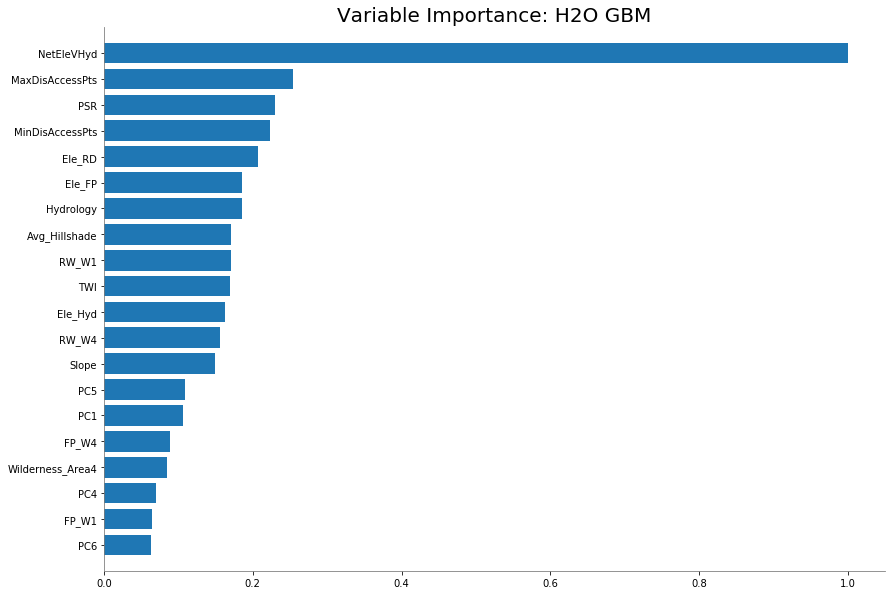

In [0]:
best_model.varimp_plot(20)

## IV. Results


Based on the analysis flow, the final model with best performance is **H2O Gradient Boosting Machine (GBM)**. The model returns an accuracy of **86.44%** on the holdout data.

We conclude the major two contributors for enhancement tuning are as follows: 


**Multi-stage Ensemble:**

H2O GBM model is a forward learning ensemble method. Its heuristic is that an increasing refined approximation can return a better prediction. It builds classification trees on all the features of the dataset. Based on our Grid Search, tree-based models can be a good fit for predicting forest cover type after feature engineering. Moreover, ensemble model enhances the results by combining multiple models, and they are unlikely to overfit.

**Feature Enginnering:**

Feature engineering is also a critical part for model enhancement to let variables be less repetitive and more informative for models. The top four important variables for H20 GBM are (1) difference between elevation and vertical distance to hydrology, (2) max distance between horizontal distance to fire points and roadways, and (3) PSR, and (4) min distance between horizontal distance to fire points and roadways. All of them are new continuous variables that the team has developed after background understanding of potential environmental characters of one 30 x 30 meter area. 





## V. Conclusion and Further Study

This study has applied machine learning techniques to accurately predict forest cover type.  These results indicate that by applying this study's approach to cover type prediction, forest service personnel can better focus their efforts and resources to areas with cover types that are most susceptible to fires.  However, it is important to note that the study's model has only been applied to a data containing 7 classes while there are hundreds of species of flora in the Roosevelt National Forest where these data were collected and thousands in other forests.  While the vast majority of confusion in our modeling of the training data was limited to two classes, more realistic case studies will undoubtedly have a larger confusion problem.  Indeed, our confusion matrix indicates the final model still has difficulty differentiating between Spur/Fir and Lodgepole Pine.  These classes have similar geographic spreading and necessary environmental conditions. Further study can analyze methods to better differentiate Cover Type 1 and 2 as well as confusion that typically exists among classes outside these data. 

Being able to identify features or feature transformations that minimize this confusion is essential and will likely take the bulk of analysis time.  These efforts may be advanced with the application of deep learning to automate feature engineering, but also with the help of additional data such as:
- Ground and surface water hydrology
- Remotely sensed data
- Rainfall and meteorological conditions - both local and neighboring
- Landsat data
- and/or Drone and LIDAR imagery
A more robust model might balance between the cartographic information analyzed in this study and these additional sources of information. 

One of the broader applications for forest cover type is to prevent wildfire. In future analysis, researchers can target to predict probability of fire, based on the current analysis for forest cover type and other influence for wildfire. Model can include information such as soil moisture, mineral content, ground and surface water hydrology, rainfall and meteorological conditions, *etc.* Finally, given the apparent and disruptive effects of rapid climate change, applying cover type prediction analyses to a time series context is important.  Understanding in what way environments are changing and how quickly they undergo such change is essential to disaster prevention and resource conservation.



## Learning

We approached this problem as a usual Kaggle challenge. That is, we split the train data into 80-20 for training and validation during feature selection, and expected to use the Kaggle test data for evaluation. After we finished the feature engineering, we found out that the test data were unlabeled and therefore unusable for evaluation. Therefore, we followed with the 60-20-20 split after discussion with the professor, and used fold cross validation with different random seeds to re-randomize and avoid overfitting. While we avoided looking at the original Kaggle test data as a proper procedure for model engineering, we learned that a simple sanity check on hold out data (short of actual analysis) may be necessary to ensure usability of test data after training. We expect that our re-shuffling, re-randomization, and cross validation mitigated any bias that may have been introduced during our feature selection process.  

## VI. Appendix

###1. Data Visualization

In [0]:
# Size of full training.csv dataset before train_test_split
print(dataset.shape)

(15120, 55)


In [0]:
# Statistical summary data for each column

pd.set_option('display.max_columns', None)
print(dataset.describe())

          Elevation        Aspect         Slope  \
count  15120.000000  15120.000000  15120.000000   
mean    2749.322553    156.676653     16.501587   
std      417.678187    110.085801      8.453927   
min     1863.000000      0.000000      0.000000   
25%     2376.000000     65.000000     10.000000   
50%     2752.000000    126.000000     15.000000   
75%     3104.000000    261.000000     22.000000   
max     3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       32.000000   
75%            

In [0]:
#Statistical Summary data for each column group by Cover Type

print(dataset.groupby('Cover_Type').describe())

           Elevation                                                    \
               count         mean         std     min      25%     50%   
Cover_Type                                                               
1             2160.0  3128.025926  156.124988  2525.0  3036.00  3144.0   
2             2160.0  2922.540278  185.778268  2169.0  2802.00  2931.5   
3             2160.0  2398.423148  194.108147  1903.0  2270.00  2409.0   
4             2160.0  2223.420370  102.929940  1989.0  2140.00  2230.5   
5             2160.0  2786.801389   96.177469  2482.0  2729.00  2793.0   
6             2160.0  2423.276852  188.966981  1863.0  2319.75  2430.0   
7             2160.0  3362.769907  109.126811  2870.0  3299.00  3364.0   

                             Aspect                                            \
                75%     max   count        mean         std  min   25%    50%   
Cover_Type                                                                      
1           3234

In [0]:
# all data is complete, non-null int64 type
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 55 columns):
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_Type1                            15120 non-null int64
Soil_T

#### 1.1 Net Elevation V.Hydrology

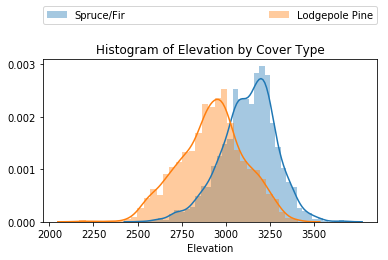

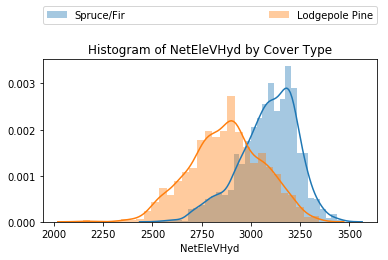

In [0]:
def hist_by_coverType(data, cols):
    x = {}
    for col in cols:
        for i in range(2):
            x[i+1] = data[data['Cover_Type'] == i + 1][col]

        labels = ['Spruce/Fir', 'Lodgepole Pine']
        fig, ax = plt.subplots(figsize=(6, 3))

        for a in x.values():
            sns.distplot(a, ax=ax, kde=True, label = labels[:2])
        plt.legend(labels[:2], loc='best', ncol=2, mode="expand", borderaxespad=0., bbox_to_anchor=(0., 1.22, 1., .102))
        plt.title('Histogram of {} by Cover Type'.format(col))
        plt.xticks(np.arange(2000, 3750, 250))
        plt.yticks(np.arange(0, 0.004, 0.001))

 
def compare(data):
    new_dataset = engr_new_features(data)
    hist_by_coverType(data, ['Elevation'])
    hist_by_coverType(new_dataset, ['NetEleVHyd'])
    
compare(dataset)

### 2. Analysis of Soil Types

#### 2.1 PCA

Fraction of variance explained by first 25 components: 0.9842721640276579


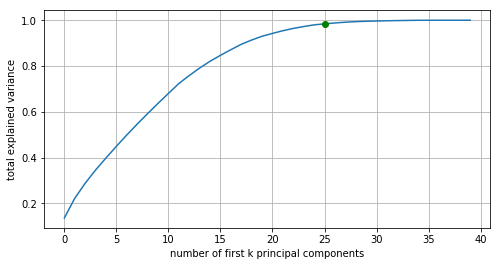

In [0]:
def run_pca(data):
    # Get Soil Types
    soil_pca = data.loc[:,'Soil_Type1':'Soil_Type40']
    soil_pca.head()
    
    X, X1, Y, Y1 = train_test_split(
        soil_pca, data['Cover_Type'], test_size=0.2, random_state=seed)
    
    pca = PCA().fit(soil_pca)
    cumulative_sum_variance = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(8,4))
    plt.plot(cumulative_sum_variance)
    i = 25
    plt.plot(i, cumulative_sum_variance[i], 'go')
    plt.grid()
    plt.xlabel('number of first k principal components')
    plt.ylabel('total explained variance');

    print('Fraction of variance explained by first {} components: {}'.format(i, cumulative_sum_variance[i]))

run_pca(dataset)

#### 2.2 L1 Regularization and PCA

different alpha values: [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
best alpha:
 0.00011925870045806349
Soils to Pick: ['Soil_Type1', 'Soil_Type2', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'] 37
Fraction of variance explained by first 25 componets: 0.9853177275047281


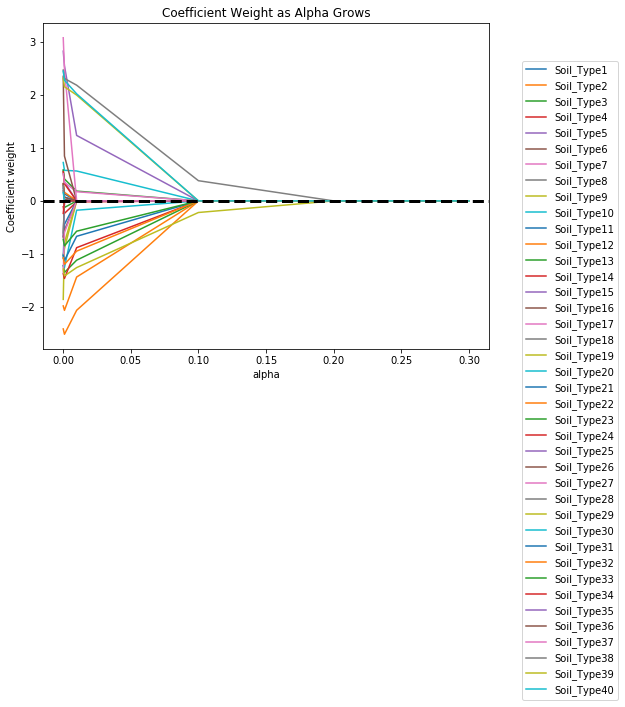

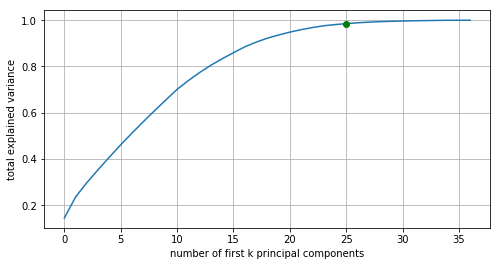

In [0]:
from sklearn.linear_model import Lasso, LassoCV

def pretty_print_linear(coefs, names = None, sort = False):
    """
      Citation:
      http://ethen8181.github.io/machine-learning/regularization/regularization.html
    """
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

def weight_versus_alpha_plot(weight, alphas, features):
    """
      Citation:
      http://ethen8181.github.io/machine-learning/regularization/regularization.html
    """
    fig = plt.figure(figsize = (8, 6))
    
    # ensure that the weight is an array
    weight = np.array(weight)
    for col in range(weight.shape[1]):
        plt.plot(alphas, weight[:, col], label = features[col])

    plt.axhline(0, color = 'black', linestyle = '--', linewidth = 3)
    
    # manually specify the coordinate of the legend
    plt.legend(bbox_to_anchor = (1.3, 0.9))
    plt.title('Coefficient Weight as Alpha Grows')
    plt.ylabel('Coefficient weight')
    plt.xlabel('alpha')
    return fig
 
def run_L1regression(data):
    """
      Citation:
      http://ethen8181.github.io/machine-learning/regularization/regularization.html
    """
    # Get Soil Types
    soil_types = data.loc[:,'Soil_Type1':'Soil_Type40']
    
    # Let us use hydrology as the dependent variable
    X, X1, Y, Y1 = train_test_split(
        soil_types, data['Cover_Type'], test_size=0.2, random_state=seed)
    
    # does the same thing above except for lasso
    alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    print('different alpha values:', alphas)
    lasso_weight = []
    names = []
    for i in range (1,41):
        names.append('Soil_Type{}'.format(i))
    
    
    for alpha in alphas:    
        lasso = Lasso(alpha = alpha)
        lasso.fit(X, Y)
        lasso_weight.append(lasso.coef_)
    lasso_fig = weight_versus_alpha_plot(lasso_weight, alphas, soil_types.columns)
    
    lasso_cv = LassoCV(n_alphas = 10)
    lasso_cv.fit(X, Y)

    # examine the coefficients and the errors of the predictions 
    # using the best alpha value
    y_pred = lasso_cv.predict(X1)
    print('best alpha:\n', lasso_cv.alpha_)

    lasso1 = Lasso(alpha = lasso_cv.alpha_)
    lasso1.fit(X, Y)
     
    soils_to_pick =  [names[i] for i in range(len(lasso1.coef_)) if lasso1.coef_[i] != 0]
    print('Soils to Pick:', soils_to_pick , len(soils_to_pick))
    return soils_to_pick
    
def run_pca_after_L1(data, cols):
    # Get Soil Types
    soil_pca = data[cols]
    
    X, X1, Y, Y1 = train_test_split(
        soil_pca, data['Cover_Type'], test_size=0.2, random_state=seed)
    
    pca = PCA().fit(soil_pca)
    cumulative_sum_variance = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(8,4))
    plt.plot(cumulative_sum_variance)
    i = 25
    plt.plot(i, cumulative_sum_variance[i], 'go')
    plt.grid()
    plt.xlabel('number of first k principal components')
    plt.ylabel('total explained variance');

    print('Fraction of variance explained by first {} componets: {}'.format(i, cumulative_sum_variance[i]))
    
def run_expt(data):
    soils_to_pick = run_L1regression(data)
    run_pca_after_L1(data, soils_to_pick)
    
run_expt(dataset)

#### 2.3 Re-categorization of Soil Types

In [0]:
def open_file_from_gdrive():
  link = 'https://drive.google.com/open?id=1HVZQ9ZHsrSEKQeQcf2YYT-ffdpoiOqvg'

  fluff, id = link.split('=')
  print (id) # Verify that you have everything after '='

  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('soil_character.csv')  
  soil_char = pd.read_csv('soil_character.csv')
  soil_char.head()
  return soil_char

1HVZQ9ZHsrSEKQeQcf2YYT-ffdpoiOqvg
   Warm  Extremely_Bouldery  Rubbly  ...  Extremely_Stony  Stony  Cover_Type
0     0                   0       0  ...                1      0           5
1     0                   0       0  ...                1      0           5
2     0                   0       0  ...                0      1           2
3     0                   0       0  ...                1      0           2
4     0                   0       0  ...                1      0           5

[5 rows x 7 columns]


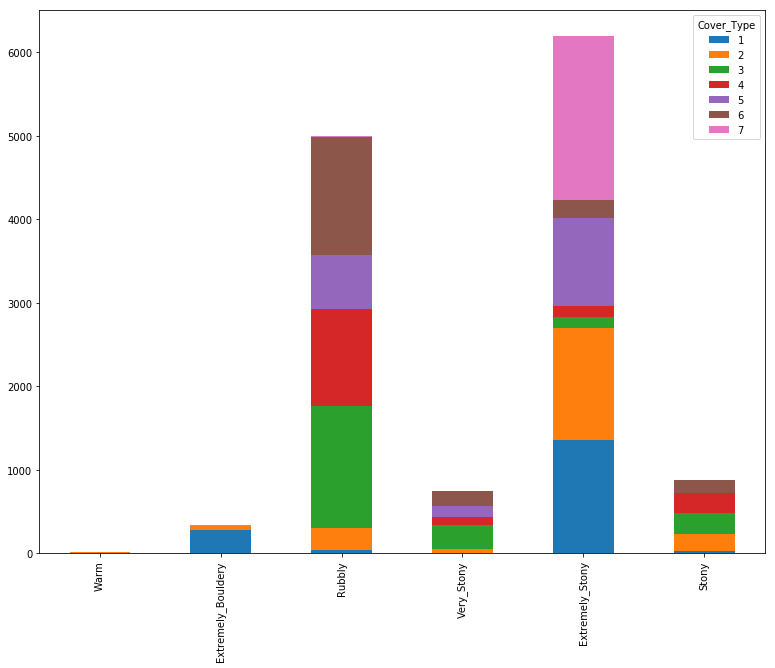

In [0]:
def create_new_soil_types(data):
    
    #soil_char = pd.read_csv('soil_character.csv')
    soil_char = open_file_from_gdrive() #Comment this and use above line for reading from local drive

    # Get the soil types 
    soil = data.iloc[:,14:54]

    # Merge based on soil type ID
    soil_cat = pd.Series(soil.columns[np.where(soil!=0)[1]],name='Id')
    soil_cat = soil_cat.str[9:]
    soil_cat = soil_cat.to_frame()
    
    soil_cat['Id'] = soil_cat['Id'].astype(int)
    soil_cat_full = pd.merge(soil_cat,soil_char,left_on='Id', right_on='Id', how='left')

    # create a new dataset "dataset_soil" with 6 binary variables and no soil type variables
    dataset_soil = pd.DataFrame(data = soil_cat_full.iloc[:,1:], 
                    columns = ['Warm','Extremely_Bouldery','Rubbly','Very_Stony','Extremely_Stony','Stony'])
            
    dataset_soil[['Warm','Extremely_Bouldery','Rubbly','Very_Stony','Extremely_Stony','Stony']] = \
            soil_cat_full.iloc[:,1:]
    dataset_soil[['Cover_Type']] = dataset[['Cover_Type']]
    print(dataset_soil.head())
    
    
    covergroup_c = dataset_soil[['Warm','Extremely_Bouldery','Rubbly','Very_Stony','Extremely_Stony','Stony']].groupby(dataset_soil['Cover_Type']).sum()
    covergroup_c.T.plot(kind='bar', stacked=True, figsize=(13,10))
    #return dataset_soil


create_new_soil_types(dataset)

### Model Selection (AutoML)

The final feature set used to train the AutoML

In [0]:
list(enumerate(final_ftr_set.columns))

[(0, 'NetEleVHyd'),
 (1, 'Hydrology'),
 (2, 'MaxDisAccessPts'),
 (3, 'MinDisAccessPts'),
 (4, 'Slope'),
 (5, 'PSR'),
 (6, 'TWI'),
 (7, 'Avg_Hillshade'),
 (8, 'Delta1_HS'),
 (9, 'Delta2_HS'),
 (10, 'MeanDelta_HS'),
 (11, 'Wilderness_Area1'),
 (12, 'Wilderness_Area2'),
 (13, 'Wilderness_Area3'),
 (14, 'Wilderness_Area4'),
 (15, 'PC1'),
 (16, 'PC2'),
 (17, 'PC3'),
 (18, 'PC4'),
 (19, 'PC5'),
 (20, 'PC6'),
 (21, 'PC7'),
 (22, 'PC8'),
 (23, 'PC9'),
 (24, 'PC10'),
 (25, 'PC11'),
 (26, 'PC12'),
 (27, 'PC13'),
 (28, 'PC14'),
 (29, 'PC15'),
 (30, 'PC16'),
 (31, 'PC17'),
 (32, 'PC18'),
 (33, 'PC19'),
 (34, 'PC20'),
 (35, 'PC21'),
 (36, 'PC22'),
 (37, 'PC23'),
 (38, 'PC24'),
 (39, 'PC25'),
 (40, 'Ele_RD'),
 (41, 'Ele_FP'),
 (42, 'Ele_Hyd'),
 (43, 'RW_W1'),
 (44, 'RW_W4'),
 (45, 'FP_W1'),
 (46, 'FP_W4'),
 (47, 'Elev_38'),
 (48, 'Elev_39'),
 (49, 'Elev_40')]

In [0]:
# We need to concatenate the Cover Type in order for the AutoML function to work
h2 = pd.concat([final_ftr_set, dataset['Cover_Type']], axis=1, join='inner')

h2.columns = h2.columns.map(str)
h2.head()

,NetEleVHyd,Hydrology,MaxDisAccessPts,MinDisAccessPts,Slope,PSR,TWI,Avg_Hillshade,Delta1_HS,Delta2_HS,MeanDelta_HS,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,Ele_RD,Ele_FP,Ele_Hyd,RW_W1,RW_W4,FP_W1,FP_W4,Elev_38,Elev_39,Elev_40,Cover_Type
0,-0.134228,0.252905,1.759299,4.779041,-1.000000,-4.043891e-01,-0.423466,0.380952,0.0,0.0,0.0,1,0,0,0,-3.484310,14.687389,1.106957,0.657095,0.434072,0.329544,-0.219868,0.116653,0.096255,-0.073813,3.492462e-13,-3.044798e-13,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.651230,0.645223,0.663818,6.748078e-01,6.717500e-01,6.784806e-01,6.818108e-01,0.114684,-0.855440,-0.054194,-0.535193,-0.0,3.992052,0.0,-0.0,-0.0,-0.0,5
1,-0.134228,0.085870,1.687584,4.832656,-1.083333,-4.315993e-01,-0.496563,0.460317,0.0,0.0,0.0,1,0,0,0,-3.484310,14.687389,1.106957,0.657095,0.434072,0.329544,-0.219868,0.116653,0.096255,-0.073813,2.100811e-14,1.219559e-13,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.651230,0.645223,0.663818,6.748078e-01,6.717500e-01,6.784806e-01,6.818108e-01,0.136826,-0.878791,-0.019108,-0.614874,-0.0,3.949136,0.0,-0.0,-0.0,-0.0,5
2,0.057718,0.317550,2.794642,2.481722,-0.500000,1.889673e-16,-0.066593,0.476190,0.0,0.0,0.0,1,0,0,0,0.786121,0.566928,0.155625,0.070274,0.049325,-0.019250,0.041226,-0.358884,-0.323699,0.266460,-3.367308e-01,3.625280e-01,0.791353,1.602527,2.086843,2.959729,3.83299,3.942560,15.196354,95.707491,-13.772399,-1.107152e+01,-8.072092e+00,-6.407134e+00,-5.804173e+00,0.088408,0.276177,0.022682,1.237716,0.0,3.866481,0.0,0.0,0.0,0.0,2
3,-0.038926,0.293780,2.794642,2.627945,0.250000,2.252880e-01,0.427433,0.333333,0.0,0.0,0.0,1,0,0,0,-0.285156,-0.332733,-0.602857,-1.224272,-3.996549,-60.091108,-3.724672,2.460337,1.429911,-0.900780,6.676187e-01,-6.693694e-01,-0.312451,-0.477024,-0.251184,-0.234169,-0.07550,-0.066672,-0.007750,-0.007396,-0.007206,-3.318818e-13,-1.424432e-13,-2.148972e-13,-1.818187e-13,0.053396,0.178509,0.013317,1.177955,0.0,3.938009,0.0,0.0,0.0,0.0,2
4,-0.134228,-0.129064,1.666151,4.788790,-1.083333,-3.639479e-01,-0.521254,0.428571,0.0,0.0,0.0,1,0,0,0,-3.484310,14.687389,1.106957,0.657095,0.434072,0.329544,-0.219868,0.116653,0.096255,-0.073813,-1.736463e-13,1.532325e-12,0.122934,0.207862,0.334532,0.341159,0.50249,0.453218,0.651230,0.645223,0.663818,6.748078e-01,6.717500e-01,6.784806e-01,6.818108e-01,0.132460,-0.842584,0.027834,-0.614210,-0.0,3.907014,0.0,-0.0,-0.0,-0.0,5


In [0]:
# Create a training set for the AutoML to use

dataset = h2.copy()
labels = dataset['Cover_Type']

train_data, test_data, train_labels, test_labels = train_test_split(dataset, labels, test_size=0.2, random_state=seed) #testing without PC2
# train_data, test_data, train_labels, test_labels = train_test_split(dataset.loc[:,'Elevation_Scaled':'Cardinal_West'], labels, test_size=0.2, random_state=1)
print('training data set: ', train_data.shape, '\n')
print(train_data.info())
print('\n testing data set: ', test_data.shape)
print(test_data.info())
print('\n training data labels: ', len(train_labels), '\n')
print(train_labels[0:5])
print('\ntesting labels: ', len(test_labels), '\n')
print(test_labels[0:5])

training data set:  (12096, 51) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12096 entries, 7366 to 2732
Data columns (total 51 columns):
NetEleVHyd          12096 non-null float64
Hydrology           12096 non-null float64
MaxDisAccessPts     12096 non-null float64
MinDisAccessPts     12096 non-null float64
Slope               12096 non-null float64
PSR                 12096 non-null float64
TWI                 12096 non-null float64
Avg_Hillshade       12096 non-null float64
Delta1_HS           12096 non-null float64
Delta2_HS           12096 non-null float64
MeanDelta_HS        12096 non-null float64
Wilderness_Area1    12096 non-null int64
Wilderness_Area2    12096 non-null int64
Wilderness_Area3    12096 non-null int64
Wilderness_Area4    12096 non-null int64
PC1                 12096 non-null float64
PC2                 12096 non-null float64
PC3                 12096 non-null float64
PC4                 12096 non-null float64
PC5                 12096 non-null float64
PC6

In [0]:
#Installs the files needed for AutoML

!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 122.7MB 195kB/s 
  Created wheel for h2o: filename=h2o-3.26.0.2-py2.py3-none-any.whl size=122725647 sha256=33fc1bce8f9fd2024a58e26f15d18664d1d743fd6bbba513c3a2fe700e87b0fd
  Stored in directory: /root/.cache/pip/wheels/76/01/62/d6b7bfc9d599463401118db95eab37c134a6f24040828d31ab
Successfully built h2o


In [0]:
import h2o
from h2o.automl import H2OAutoML


#Initialize H2O instance
h2o.init()


#Import training and testing data into H20 Dataframes
train = h2o.H2OFrame(train_data)
test = h2o.H2OFrame(test_data)

train.head()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,17 mins 01 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_unknownUser_qij3x0
H2O cluster total nodes:,1
H2O cluster free memory:,2.916 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


NetEleVHyd,Hydrology,MaxDisAccessPts,MinDisAccessPts,Slope,PSR,TWI,Avg_Hillshade,Delta1_HS,Delta2_HS,MeanDelta_HS,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,Ele_RD,Ele_FP,Ele_Hyd,RW_W1,RW_W4,FP_W1,FP_W4,Elev_38,Elev_39,Elev_40,Cover_Type
0.861745,0.392681,-0.0781041,-0.403737,-0.5,1.03445,-0.0277558,0.619048,0,0,0,0,0,1,0,-0.294267,-0.343635,-0.618519,-1.27274,-4.59912,63.217,-3.23033,2.31215,1.36939,-0.869698,0.645693,-0.648359,-0.304416,-0.465592,-0.24242,-0.22629,-0.0678798,-0.0599595,0,0,0,0.00716432,0.00698676,0.00691354,0.00687624,0.0869462,-0.265872,0.331729,0,0,0,0,0.84478,0,0,7
-0.669799,-0.346823,-0.0945904,0.712429,0.916667,-0.324057,-0.0791632,-0.984127,0,0,0,0,0,0,1,-1.17628,-1.96575,8.63607,1.44254,0.725857,0.558346,-0.370943,0.348139,0.275828,-0.205505,0.119419,-0.124398,0,0,0.142717,0.141201,0.296521,0.265424,0.398633,0.389259,0.391879,0.399452,0.394265,0.394801,0.395011,0.267348,-0.157096,0.252971,0,-0.366534,0,0.215379,0,0,0,4
0.902013,-0.575574,2.4575,0.0170593,-0.75,1.21117,-0.54725,0.746032,0,0,0,1,0,0,0,0.376402,0.293697,0,-0.0933828,-0.107368,-0.179712,0.176048,-0.651861,-0.623728,0.541871,-0.643561,0.708845,3.52405,37.1851,-6.27625,-3.10719,-2.41111,-1.96322,-1.65311,-1.44495,-1.26069,-1.21985,-1.14674,-1.09612,-1.07215,1.68068,1.98927,-0.490186,1.97344,0,2.33578,0,0,0,0.851648,7
-0.189262,-0.685677,-0.270582,0.433794,-0.416667,-0.218109,-0.585194,0.269841,0,0,0,0,0,1,0,0.48089,0.369789,0.0475966,-0.0399881,-0.0528975,-0.122584,0.126872,-0.540638,-0.505625,0.429896,-0.514739,0.561518,1.72506,4.82577,21.6036,-9.14124,-5.50404,-4.0623,-2.72839,-2.26059,-1.86192,-1.78692,-1.6523,-1.55615,-1.51168,0.106732,0.0245173,0.185547,0,0,0,0,0,0,0,6
0.875168,1.64627,2.13725,-0.406174,0.333333,0.110085,1.95966,-0.68254,0,0,0,0,0,1,0,-0.0900329,-0.11659,-0.338727,-0.592546,-0.865332,-1.16354,1.3005,-6.41984,31.0341,-3.93953,2.10933,-1.92496,-0.577515,-0.832507,-0.509139,-0.457359,-0.288114,-0.252483,-0.215323,-0.203138,-0.194823,-0.185907,-0.18024,-0.177337,-0.175885,1.75356,1.68999,1.52868,0,0,0,0,0,0.928571,0,7
0.24698,-0.355828,0.251211,-0.0779854,-0.5,0.98525,-0.414684,0.587302,0,0,0,0,0,1,0,-0.38471,-0.456265,-0.797233,-1.96482,13.2264,3.19978,-1.45106,1.44902,0.965297,-0.648418,0.483125,-0.490585,-0.236463,-0.367234,-0.165726,-0.15646,0,0,0.0700335,0.0671271,0.0658007,0.0726651,0.0710059,0.0703994,0.0700875,0.0377775,0.0260566,-0.0571867,0,0,0,0,0,0,0,5
-0.0134228,-0.685677,2.8033,2.5199,-0.25,0.239937,-0.585194,-0.015873,0,0,0,1,0,0,0,-0.285156,-0.332733,-0.602857,-1.22427,-3.99655,-60.0911,-3.72467,2.46034,1.42991,-0.90078,0.667619,-0.669369,-0.312451,-0.477024,-0.251184,-0.234169,-0.0755003,-0.0666724,-0.00775003,-0.00739616,-0.00720615,0,0,0,0,-0.111428,-0.352982,0.062163,1.22908,0,3.8935,0,0,0,0,5
-0.314094,-0.531806,-0.504688,0.991064,-0.583333,-0.259372,-0.514491,0.0793651,0,0,0,0,0,1,0,26.2607,2.4427,0.661273,0.444465,0.318722,0.231093,-0.150207,0,0,0,-0.0694643,0.0733457,0.212247,0.366968,0.490861,0.513455,0.684537,0.621597,0.893615,0.897981,0.944323,0.961571,0.965829,0.984528,0.994054,0.317398,0.0171123,0.208193,0,0,0,0,0,0,0,6
-0.251007,-0.575574,-0.236785,1.14703,-1,0.719215,-0.566222,0.539683,0,0,0,0,0,0,1,-0.0711101,-0.0972515,-0.318708,-0.555535,-0.786899,-1.04196,1.1252,-4.74534,-30.3035,-5.87824,2.62449,-2.32064,-0.618548,-0.884021,-0.544321,-0.486545,-0.315463,-0.276179,-0.240865,-0.226915,-0.217214,-0.208015,-0.201538,-0.198164,-0.19648,0.223487,-0.0986915,0.195284,0,-0.658699,0,0.29088,0,0,0,6
-0.0765101,0.515386,-0.35425,-0.00731113,-0.5,-0.249338,0.0356744,0,0,0,0,0,0,1,0,0.48089,0.369789,0.0475966,-0.0399881,-0.0528975,-0.122584,0.126872,-0.540638,-0.505625,0.429896,-0.514739,0.561518,1.72506,4.82577,21.6036,-9.14124,-5.50404,-4.0623,-2.72839,-2.26059,-1.86192,-1.78692,-1.6523,-1.55615,-1.51168,0.047568,0.0653937,-0.0870776,0,0,0,0,0,0,0,3


In [0]:
#WARNING!! This Step will Take more than 40 minutes to run
# Run AutoML and print leaderboard ranked by logloss (smaller the better)

# x = train.columns
# y = "Cover_Type"
# x.remove(y)

# train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()

# aml = H2OAutoML(max_models=20, seed=1)
# aml.train(x=x, y=y, training_frame=train)

# lb = aml.leaderboard
# lb.head(rows=lb.nrows)

# aml.leader
# preds = aml.leader.predict(test)

# lb.head(rows=lb.nrows)

AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_AutoML_20190804_144546,0.118921,0.333101,0.311406,0.0969737
StackedEnsemble_BestOfFamily_AutoML_20190804_144546,0.120158,0.336702,0.31354,0.0983073
GBM_1_AutoML_20190804_144546,0.12991,0.348624,0.322412,0.103949
XGBoost_1_AutoML_20190804_144546,0.130965,0.344299,0.323173,0.104441
DRF_1_AutoML_20190804_144546,0.132057,0.42626,0.35412,0.125401
XGBoost_2_AutoML_20190804_144546,0.141038,0.37786,0.341539,0.116649
XGBoost_3_AutoML_20190804_144546,0.149183,0.39067,0.348752,0.121628
GBM_2_AutoML_20190804_144546,0.150322,0.410842,0.35763,0.127899
GLM_grid_1_AutoML_20190804_144546_model_1,0.413724,1.74886,0.824537,0.679861


#### AutoML Results

We see that Stacked Ensemble modles perform the best. However, in order to tune our own final model, we select the best performing individual model - a GBM (model_id: GBM_1_AutoML_20190804_144546) with an accuracy of: 0.8698744. 

In [0]:
# perf = aml.leader.show()
# perf

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190804_144546

No model summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.005819147441039074
RMSE: 0.07628333658826857

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.09697367968533217
RMSE: 0.3114059724625271


In [0]:
# aml.leader.confusion_matrix(test)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,6,7,Error,Rate
343.0,68.0,1.0,0.0,5.0,1.0,21.0,0.2186788,96 / 439
59.0,309.0,12.0,0.0,23.0,3.0,5.0,0.2481752,102 / 411
0.0,0.0,365.0,19.0,5.0,29.0,0.0,0.1267943,53 / 418
0.0,0.0,8.0,422.0,0.0,8.0,0.0,0.0365297,16 / 438
1.0,23.0,6.0,0.0,396.0,2.0,0.0,0.0747664,32 / 428
1.0,7.0,40.0,7.0,4.0,412.0,0.0,0.1252654,59 / 471
14.0,2.0,0.0,0.0,0.0,0.0,403.0,0.0381862,16 / 419
418.0,409.0,432.0,448.0,433.0,455.0,429.0,0.1236772,"374 / 3,024"


In [0]:
# aml.leaderboard['model_id']

model_id
StackedEnsemble_AllModels_AutoML_20190804_144546
StackedEnsemble_BestOfFamily_AutoML_20190804_144546
GBM_1_AutoML_20190804_144546
XGBoost_1_AutoML_20190804_144546
DRF_1_AutoML_20190804_144546
XGBoost_2_AutoML_20190804_144546
XGBoost_3_AutoML_20190804_144546
GBM_2_AutoML_20190804_144546
GLM_grid_1_AutoML_20190804_144546_model_1


In [0]:
#This model_id will have to be updated if AutoML is run again
# model1 = h2o.get_model('GBM_1_AutoML_20190804_144546')

In [0]:
# model1.show()

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20190804_144546

Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,111.0,777.0,561501.0,6.0,6.0,6.0,27.0,64.0,52.872585




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.019355018682955846
RMSE: 0.13912231554626975
LogLoss: 0.09730970147832119
Mean Per-Class Error: 0.007485497241154963
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,6,7,Error,Rate
1693.0,22.0,0.0,0.0,4.0,0.0,2.0,0.0162696,"28 / 1,721"
24.0,1696.0,7.0,0.0,12.0,10.0,0.0,0.0303030,"53 / 1,749"
0.0,0.0,1740.0,0.0,0.0,2.0,0.0,0.0011481,"2 / 1,742"
0.0,0.0,0.0,1722.0,0.0,0.0,0.0,0.0,"0 / 1,722"
0.0,0.0,2.0,0.0,1728.0,2.0,0.0,0.0023095,"4 / 1,732"
0.0,0.0,2.0,0.0,2.0,1685.0,0.0,0.0023683,"4 / 1,689"
0.0,0.0,0.0,0.0,0.0,0.0,1741.0,0.0,"0 / 1,741"
1717.0,1718.0,1751.0,1722.0,1746.0,1699.0,1743.0,0.0075231,"91 / 12,096"


Top-7 Hit Ratios: 


k,hit_ratio
1,0.9924769
2,0.9992560
3,0.9999173
4,1.0
5,1.0
6,1.0
7,1.0



ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.10394943948611615
RMSE: 0.322411909653034
LogLoss: 0.3486239633571241
Mean Per-Class Error: 0.12991030847866322
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,6,7,Error,Rate
1310.0,292.0,0.0,0.0,31.0,2.0,86.0,0.2388146,"411 / 1,721"
302.0,1236.0,38.0,0.0,125.0,40.0,8.0,0.2933105,"513 / 1,749"
0.0,8.0,1481.0,58.0,19.0,176.0,0.0,0.1498278,"261 / 1,742"
0.0,0.0,29.0,1677.0,0.0,16.0,0.0,0.0261324,"45 / 1,722"
3.0,45.0,27.0,0.0,1642.0,15.0,0.0,0.0519630,"90 / 1,732"
2.0,17.0,123.0,38.0,14.0,1495.0,0.0,0.1148609,"194 / 1,689"
50.0,10.0,0.0,0.0,0.0,0.0,1681.0,0.0344630,"60 / 1,741"
1667.0,1608.0,1698.0,1773.0,1831.0,1744.0,1775.0,0.1301257,"1,574 / 12,096"


Top-7 Hit Ratios: 


k,hit_ratio
1,0.8698744
2,0.9801587
3,0.9962798
4,0.9990079
5,1.0
6,1.0
7,1.0


Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8698738,0.0032935,0.8764463,0.8726746,0.8710211,0.8652335,0.8639934
err,0.1301262,0.0032935,0.1235537,0.1273253,0.1289789,0.1347664,0.1360066
err_count,314.8,7.9422917,299.0,308.0,312.0,326.0,329.0
logloss,0.3486243,0.0034119,0.3445237,0.3486243,0.3452691,0.3468503,0.3578542
max_per_class_error,0.2930560,0.0092959,0.2786378,0.2914286,0.2924791,0.2853186,0.3174157
mean_per_class_accuracy,0.8701999,0.0026279,0.8736128,0.8747572,0.869178,0.8691195,0.8643321
mean_per_class_error,0.1298001,0.0026279,0.1263872,0.1252428,0.130822,0.1308805,0.1356678
mse,0.1039497,0.0016323,0.1007666,0.1029440,0.1033382,0.1050069,0.1076927
r2,0.974001,0.0003346,0.9743817,0.9743699,0.973475,0.9744075,0.973371
rmse,0.3223925,0.0025272,0.3174376,0.3208489,0.3214626,0.3240477,0.3281657


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
,2019-08-04 15:43:46,2 min 51.816 sec,0.0,0.8571429,1.9459101,0.8692956
,2019-08-04 15:43:48,2 min 53.158 sec,5.0,0.6347865,1.0420140,0.1760086
,2019-08-04 15:43:49,2 min 54.475 sec,10.0,0.5017738,0.7134641,0.1529431
,2019-08-04 15:43:50,2 min 55.770 sec,15.0,0.4249183,0.5460346,0.1323578
,2019-08-04 15:43:52,2 min 57.071 sec,20.0,0.3764473,0.4473613,0.1176422
---,---,---,---,---,---,---
,2019-08-04 15:44:11,3 min 16.694 sec,95.0,0.1621601,0.1196923,0.0147983
,2019-08-04 15:44:13,3 min 17.965 sec,100.0,0.1547356,0.1121971,0.0122354
,2019-08-04 15:44:14,3 min 19.231 sec,105.0,0.1470919,0.1049317,0.0091766
,2019-08-04 15:44:15,3 min 20.525 sec,110.0,0.1406517,0.0987155,0.0079365



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
NetEleVHyd,8101.4609375,1.0,0.2387600
MaxDisAccessPts,1886.1887207,0.2328208,0.0555883
Ele_RD,1798.8702393,0.2220427,0.0530149
Ele_Hyd,1618.4804688,0.1997764,0.0476986
MinDisAccessPts,1588.2559814,0.1960456,0.0468079
---,---,---,---
PC13,121.2048950,0.0149609,0.0035721
PC18,102.8267441,0.0126924,0.0030304
Wilderness_Area2,46.8576469,0.0057839,0.0013810
PC23,45.5462532,0.0056220,0.0013423



See the whole table with table.as_data_frame()


In [0]:
# model1.summary().as_data_frame()

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,111.0,777.0,561501.0,6.0,6.0,6.0,27.0,64.0,52.872585


In [0]:
# model1.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.8698738,0.0032934723,0.8764463,0.87267464,0.8710211,0.86523354,0.8639934
1,err,0.13012621,0.0032934723,0.123553716,0.12732534,0.12897892,0.13476643,0.13600661
2,err_count,314.8,7.9422917,299.0,308.0,312.0,326.0,329.0
3,logloss,0.3486243,0.0034118863,0.34452367,0.3486243,0.34526914,0.34685025,0.35785416
4,max_per_class_error,0.29305595,0.009295865,0.27863777,0.29142857,0.2924791,0.28531855,0.31741574
5,mean_per_class_accuracy,0.8701999,0.002627895,0.87361276,0.8747572,0.869178,0.8691195,0.86433214
6,mean_per_class_error,0.12980008,0.002627895,0.12638724,0.12524281,0.130822,0.1308805,0.13566783
7,mse,0.1039497,0.0016323375,0.1007666,0.10294404,0.10333823,0.10500694,0.10769271
8,r2,0.974001,3.3463343E-4,0.9743817,0.9743699,0.973475,0.9744075,0.973371
9,rmse,0.3223925,0.0025272141,0.31743756,0.32084894,0.32146263,0.32404774,0.32816568


In [0]:
# model1.varimp(use_pandas = True)

,variable,relative_importance,scaled_importance,percentage
0,NetEleVHyd,8101.460938,1.000000,0.238760
1,MaxDisAccessPts,1886.188721,0.232821,0.055588
2,Ele_RD,1798.870239,0.222043,0.053015
3,Ele_Hyd,1618.480469,0.199776,0.047699
4,MinDisAccessPts,1588.255981,0.196046,0.046808
5,Ele_FP,1440.004272,0.177746,0.042439
6,Wilderness_Area4,1435.126465,0.177144,0.042295
7,PC1,1258.562500,0.155350,0.037091
8,Hydrology,1126.260742,0.139019,0.033192
9,RW_W1,940.531433,0.116094,0.027719


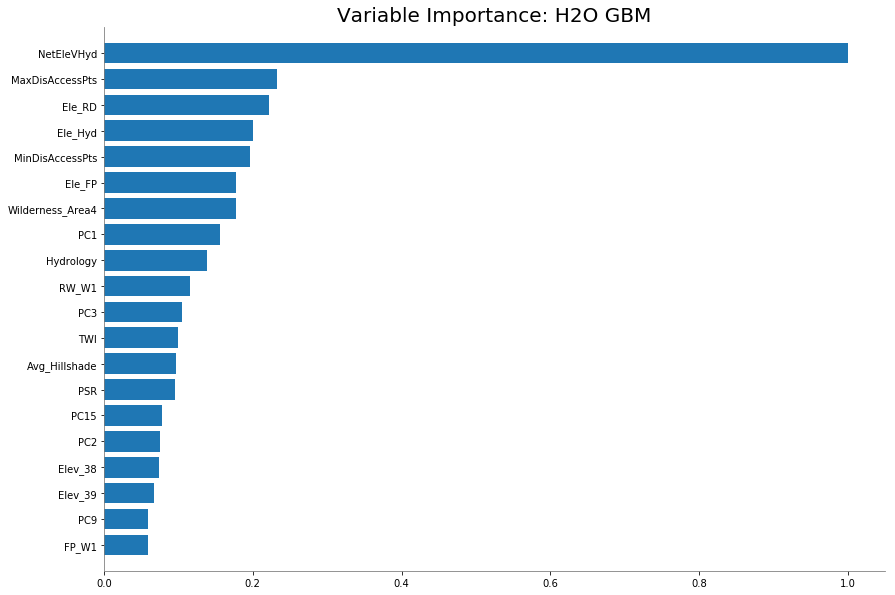

In [0]:
# model1.varimp_plot(20)

#### AutoML GBM Parameters

In [0]:
# params_list = []
# for key, value in model1.params.items():
#     params_list.append(str(key)+" = "+str(value['actual']))
# params_list

["model_id = {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_1_AutoML_20190804_144546', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_1_AutoML_20190804_144546'}",
 "training_frame = {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'automl_training_py_3_sid_8f9c', 'type': 'Key<Frame>', 'URL': '/3/Frames/automl_training_py_3_sid_8f9c'}",
 'validation_frame = None',
 'nfolds = 5',
 'keep_cross_validation_models = False',
 'keep_cross_validation_predictions = True',
 'keep_cross_validation_fold_assignment = False',
 'score_each_iteration = False',
 'score_tree_interval = 5',
 'fold_assignment = Modulo',
 'fold_column = None',
 "response_column = {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'column_name': 'Cover_Type', 'is_member_of_frames': None}",
 'ignored_columns = []',
 'ignore_const_cols = True',
 'offset_column = None',
 'weigh

## VII. Reference

* Amiro, B.D., et al., “Boreal Forest Fires: An Increasing Issue in a Changing Climate,” submitted to the XII World Forestry Congress, 2003.  Available at http://www.fao.org/3/xii/0207-b3.htm.
* “Arapaho & Roosevelt National Forests Pawnee National Grassland,” U.S. Department of Agriculture Forest Service, www.fs.usda.gov. Available at https://www.fs.usda.gov/wps/portal/fsinternet/cs/main/!ut/p/z0/04_Sj9CPykssy0xPLMnMz0vMAfIjo8zijQwgwNHCwN_DI8zPwBcqYKBfkO2oCADIwpjI/?pname=Arapaho%2F&ss=110210&pnavid=null&navid=091000000000000&ttype=main&cid=null.
* Bache, K.  and Lichman, M.. UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science, 2013.
* Blackard, Jock A. and Denis J. Dean, “Comparative accuracies of artificial neural networks and discriminant analysis in predicting forest cover types from cartographic variables,” Computers and Electronics in Agriculture, Vol. 24, 1999, 131-151.  Available at https://web.cs.ucdavis.edu/~matloff/matloff/public_html/132/Data/ForestCover/BlackardDean.pdf.
* Butler, et al., “Influence of Slope on Fire Spread Rate,” USDA Forest Service Proceedings ,RMRS-P-46CD, March 2007.  Available at https://www.fs.fed.us/rm/pubs/rmrs_p046/rmrs_p046_075_082.pdf.
* Candel, Arno, “H20 GBM Tuning Tutorial for Python,” gbmTuning.ipynb, GutHub, commit 18a2d0cb16b31b48a1c8d55d6a959dd60373d1c0,August 2016.  Available at https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb.
* Crain, Kevin and Graham Davis, “Classifying Forest Cover Type using Cartographic Features,” unpublished report, Stanford University, December 2014.  Available at http://cs229.stanford.edu/proj2014/Kevin%20Crain,%20Graham%20Davis,%20Classifying%20Forest%20Cover%20Type%20using%20Cartographic%20Features.pdf.
* “Docs,” H2O.ai, July 26, 2019.  Available at http://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html.
* Fang, et. al, “Predicting Potential Fire Severity Using Vegetation,Topography and Surface Moisture Availability in a Eurasian Boreal Forest Landscape,” Forests, Vol. 9, Issue 3, March 2018.  Available at https://www.mdpi.com/1999-4907/9/3/130/pdf.
* “Forest Cover Type Prediction,” kaggle.com.  Available at https://www.kaggle.com/c/forest-cover-type-prediction/overview.
* Hendricks, David M., Arizona Soils, Chapter 6: The United States Soil Classification System and Its Application in Arizona, College of Agriculture, University of Arizona, Tucson, 1985. Available at http://www.library.arizona.edu/exhibits/swetc/azso/body.1_div.6.html.
* “How Aspect Works,” ArcMap, desktop.arcgis.com. Available at http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-aspect-works.htm.
* Sullivan, Carl, Kespry Inc., Phone Interview with Robert Calzaretta, July 27, 2019.  Biography available at https://www.kespry.com/people-behind-the-kespry-products-carl-sullivan/.
